# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

# Loading Thames nutrient pollution data

In [2]:
data = pd.read_csv("test_steven_temporal.csv",usecols=["Sample Date","Phosphate"])

In [3]:
data.head()

,Sample Date,Phosphate
0,10/06/2015 08:34,0.010
1,14/09/2015 00:00,0.075
2,14/09/2015 00:00,0.075
3,14/09/2015 07:45,0.150
4,14/09/2015 07:55,0.010


# Convert Sample Date to date type

In [4]:
data["Sample Date"] = pd.to_datetime(data["Sample Date"],format='%d/%m/%Y %H:%M')

# Plotting Date vs Phosphate Conc

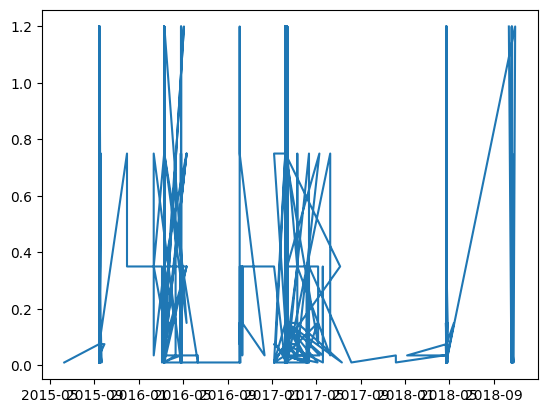

In [6]:
plt.plot(data["Sample Date"],data["Phosphate"])

## Prepping data for LSTM pytorch model

In [7]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    df.set_index('Sample Date', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'Phosphate(t-{i})'] = df['Phosphate'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Phosphate,Phosphate(t-1),Phosphate(t-2),Phosphate(t-3),Phosphate(t-4),Phosphate(t-5),Phosphate(t-6),Phosphate(t-7)
Sample Date,,,,,,,,
2015-09-14 09:20:00,0.010,0.075,1.200,0.010,0.150,0.075,0.075,0.010
2015-09-14 08:35:00,0.010,0.010,0.075,1.200,0.010,0.150,0.075,0.075
2015-09-14 00:00:00,0.035,0.010,0.010,0.075,1.200,0.010,0.150,0.075
2015-09-14 09:32:00,0.035,0.035,0.010,0.010,0.075,1.200,0.010,0.150
2015-09-14 11:36:00,0.750,0.035,0.035,0.010,0.010,0.075,1.200,0.010
...,...,...,...,...,...,...,...,...
2018-10-18 11:00:00,0.350,0.150,0.010,0.010,0.035,0.010,0.035,0.010
2018-10-18 10:30:00,0.010,0.350,0.150,0.010,0.010,0.035,0.010,0.035
2018-10-18 10:00:00,0.035,0.010,0.350,0.150,0.010,0.010,0.035,0.010


In [8]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[0.01 , 0.075, 1.2  , ..., 0.075, 0.075, 0.01 ],
       [0.01 , 0.01 , 0.075, ..., 0.15 , 0.075, 0.075],
       [0.035, 0.01 , 0.01 , ..., 0.01 , 0.15 , 0.075],
       ...,
       [0.035, 0.01 , 0.35 , ..., 0.01 , 0.035, 0.01 ],
       [0.035, 0.035, 0.01 , ..., 0.01 , 0.01 , 0.035],
       [1.2  , 0.035, 0.035, ..., 0.15 , 0.01 , 0.01 ]])

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-1.        , -0.8907563 ,  1.        , ..., -0.8907563 ,
        -0.8907563 , -1.        ],
       [-1.        , -1.        , -0.8907563 , ..., -0.76470588,
        -0.8907563 , -0.8907563 ],
       [-0.95798319, -1.        , -1.        , ..., -1.        ,
        -0.76470588, -0.8907563 ],
       ...,
       [-0.95798319, -1.        , -0.42857143, ..., -1.        ,
        -0.95798319, -1.        ],
       [-0.95798319, -0.95798319, -1.        , ..., -1.        ,
        -1.        , -0.95798319],
       [ 1.        , -0.95798319, -0.95798319, ..., -0.76470588,
        -1.        , -1.        ]])

In [10]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((2354, 7), (2354,))

In [11]:
X = dc(np.flip(X, axis=1))
X

array([[-1.        , -0.8907563 , -0.8907563 , ..., -1.        ,
         1.        , -0.8907563 ],
       [-0.8907563 , -0.8907563 , -0.76470588, ...,  1.        ,
        -0.8907563 , -1.        ],
       [-0.8907563 , -0.76470588, -1.        , ..., -0.8907563 ,
        -1.        , -1.        ],
       ...,
       [-1.        , -0.95798319, -1.        , ..., -0.76470588,
        -0.42857143, -1.        ],
       [-0.95798319, -1.        , -1.        , ..., -0.42857143,
        -1.        , -0.95798319],
       [-1.        , -1.        , -0.76470588, ..., -1.        ,
        -0.95798319, -0.95798319]])

In [12]:
# 5% test data and 95% train data

split_index = int(len(X) * 0.95)

split_index

2236

In [13]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2236, 7), (118, 7), (2236,), (118,))

In [14]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2236, 7, 1), (118, 7, 1), (2236, 1), (118, 1))

In [15]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([2236, 7, 1]),
 torch.Size([118, 7, 1]),
 torch.Size([2236, 1]),
 torch.Size([118, 1]))

In [16]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [17]:
train_dataset

In [18]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [20]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [21]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [22]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [23]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

# Pytorch LSTM model

In [24]:
learning_rate = 0.001
num_epochs = 10000
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.162

Val Loss: 0.174
***************************************************

Epoch: 2
Batch 100, Loss: 0.164

Val Loss: 0.174
***************************************************

Epoch: 3
Batch 100, Loss: 0.173

Val Loss: 0.176
***************************************************

Epoch: 4
Batch 100, Loss: 0.173

Val Loss: 0.176
***************************************************

Epoch: 5
Batch 100, Loss: 0.157

Val Loss: 0.176
***************************************************

Epoch: 6
Batch 100, Loss: 0.167

Val Loss: 0.177
***************************************************

Epoch: 7
Batch 100, Loss: 0.177

Val Loss: 0.178
***************************************************

Epoch: 8
Batch 100, Loss: 0.168

Val Loss: 0.177
***************************************************

Epoch: 9
Batch 100, Loss: 0.172

Val Loss: 0.177
***************************************************

Epoch: 10
Batch 100, Loss: 0.160

Val Loss: 0.177
********************************

Batch 100, Loss: 0.177

Val Loss: 0.182
***************************************************

Epoch: 82
Batch 100, Loss: 0.171

Val Loss: 0.180
***************************************************

Epoch: 83
Batch 100, Loss: 0.160

Val Loss: 0.180
***************************************************

Epoch: 84
Batch 100, Loss: 0.161

Val Loss: 0.181
***************************************************

Epoch: 85
Batch 100, Loss: 0.166

Val Loss: 0.180
***************************************************

Epoch: 86
Batch 100, Loss: 0.166

Val Loss: 0.180
***************************************************

Epoch: 87
Batch 100, Loss: 0.156

Val Loss: 0.179
***************************************************

Epoch: 88
Batch 100, Loss: 0.156

Val Loss: 0.179
***************************************************

Epoch: 89
Batch 100, Loss: 0.164

Val Loss: 0.181
***************************************************

Epoch: 90
Batch 100, Loss: 0.173

Val Loss: 0.180
*********************************

Batch 100, Loss: 0.167

Val Loss: 0.182
***************************************************

Epoch: 163
Batch 100, Loss: 0.158

Val Loss: 0.181
***************************************************

Epoch: 164
Batch 100, Loss: 0.161

Val Loss: 0.180
***************************************************

Epoch: 165
Batch 100, Loss: 0.161

Val Loss: 0.180
***************************************************

Epoch: 166
Batch 100, Loss: 0.160

Val Loss: 0.181
***************************************************

Epoch: 167
Batch 100, Loss: 0.165

Val Loss: 0.181
***************************************************

Epoch: 168
Batch 100, Loss: 0.162

Val Loss: 0.181
***************************************************

Epoch: 169
Batch 100, Loss: 0.159

Val Loss: 0.180
***************************************************

Epoch: 170
Batch 100, Loss: 0.160

Val Loss: 0.180
***************************************************

Epoch: 171
Batch 100, Loss: 0.164

Val Loss: 0.181
************************

Batch 100, Loss: 0.161

Val Loss: 0.180
***************************************************

Epoch: 244
Batch 100, Loss: 0.152

Val Loss: 0.180
***************************************************

Epoch: 245
Batch 100, Loss: 0.169

Val Loss: 0.183
***************************************************

Epoch: 246
Batch 100, Loss: 0.167

Val Loss: 0.181
***************************************************

Epoch: 247
Batch 100, Loss: 0.169

Val Loss: 0.180
***************************************************

Epoch: 248
Batch 100, Loss: 0.163

Val Loss: 0.181
***************************************************

Epoch: 249
Batch 100, Loss: 0.167

Val Loss: 0.182
***************************************************

Epoch: 250
Batch 100, Loss: 0.154

Val Loss: 0.180
***************************************************

Epoch: 251
Batch 100, Loss: 0.169

Val Loss: 0.181
***************************************************

Epoch: 252
Batch 100, Loss: 0.153

Val Loss: 0.180
************************

Batch 100, Loss: 0.159

Val Loss: 0.181
***************************************************

Epoch: 325
Batch 100, Loss: 0.154

Val Loss: 0.181
***************************************************

Epoch: 326
Batch 100, Loss: 0.162

Val Loss: 0.181
***************************************************

Epoch: 327
Batch 100, Loss: 0.159

Val Loss: 0.183
***************************************************

Epoch: 328
Batch 100, Loss: 0.167

Val Loss: 0.181
***************************************************

Epoch: 329
Batch 100, Loss: 0.164

Val Loss: 0.181
***************************************************

Epoch: 330
Batch 100, Loss: 0.155

Val Loss: 0.179
***************************************************

Epoch: 331
Batch 100, Loss: 0.164

Val Loss: 0.182
***************************************************

Epoch: 332
Batch 100, Loss: 0.158

Val Loss: 0.181
***************************************************

Epoch: 333
Batch 100, Loss: 0.155

Val Loss: 0.182
************************

Batch 100, Loss: 0.157

Val Loss: 0.183
***************************************************

Epoch: 406
Batch 100, Loss: 0.166

Val Loss: 0.185
***************************************************

Epoch: 407
Batch 100, Loss: 0.164

Val Loss: 0.184
***************************************************

Epoch: 408
Batch 100, Loss: 0.172

Val Loss: 0.185
***************************************************

Epoch: 409
Batch 100, Loss: 0.165

Val Loss: 0.182
***************************************************

Epoch: 410
Batch 100, Loss: 0.158

Val Loss: 0.184
***************************************************

Epoch: 411
Batch 100, Loss: 0.165

Val Loss: 0.186
***************************************************

Epoch: 412
Batch 100, Loss: 0.168

Val Loss: 0.185
***************************************************

Epoch: 413
Batch 100, Loss: 0.155

Val Loss: 0.184
***************************************************

Epoch: 414
Batch 100, Loss: 0.162

Val Loss: 0.186
************************

Batch 100, Loss: 0.153

Val Loss: 0.187
***************************************************

Epoch: 487
Batch 100, Loss: 0.150

Val Loss: 0.185
***************************************************

Epoch: 488
Batch 100, Loss: 0.158

Val Loss: 0.182
***************************************************

Epoch: 489
Batch 100, Loss: 0.149

Val Loss: 0.181
***************************************************

Epoch: 490
Batch 100, Loss: 0.154

Val Loss: 0.183
***************************************************

Epoch: 491
Batch 100, Loss: 0.159

Val Loss: 0.183
***************************************************

Epoch: 492
Batch 100, Loss: 0.164

Val Loss: 0.186
***************************************************

Epoch: 493
Batch 100, Loss: 0.169

Val Loss: 0.184
***************************************************

Epoch: 494
Batch 100, Loss: 0.153

Val Loss: 0.184
***************************************************

Epoch: 495
Batch 100, Loss: 0.150

Val Loss: 0.186
************************

Batch 100, Loss: 0.160

Val Loss: 0.185
***************************************************

Epoch: 568
Batch 100, Loss: 0.155

Val Loss: 0.185
***************************************************

Epoch: 569
Batch 100, Loss: 0.161

Val Loss: 0.187
***************************************************

Epoch: 570
Batch 100, Loss: 0.158

Val Loss: 0.184
***************************************************

Epoch: 571
Batch 100, Loss: 0.166

Val Loss: 0.188
***************************************************

Epoch: 572
Batch 100, Loss: 0.157

Val Loss: 0.184
***************************************************

Epoch: 573
Batch 100, Loss: 0.156

Val Loss: 0.183
***************************************************

Epoch: 574
Batch 100, Loss: 0.157

Val Loss: 0.184
***************************************************

Epoch: 575
Batch 100, Loss: 0.162

Val Loss: 0.184
***************************************************

Epoch: 576
Batch 100, Loss: 0.164

Val Loss: 0.184
************************

Batch 100, Loss: 0.153

Val Loss: 0.185
***************************************************

Epoch: 649
Batch 100, Loss: 0.168

Val Loss: 0.185
***************************************************

Epoch: 650
Batch 100, Loss: 0.158

Val Loss: 0.186
***************************************************

Epoch: 651
Batch 100, Loss: 0.155

Val Loss: 0.184
***************************************************

Epoch: 652
Batch 100, Loss: 0.149

Val Loss: 0.185
***************************************************

Epoch: 653
Batch 100, Loss: 0.153

Val Loss: 0.182
***************************************************

Epoch: 654
Batch 100, Loss: 0.158

Val Loss: 0.184
***************************************************

Epoch: 655
Batch 100, Loss: 0.163

Val Loss: 0.185
***************************************************

Epoch: 656
Batch 100, Loss: 0.158

Val Loss: 0.184
***************************************************

Epoch: 657
Batch 100, Loss: 0.161

Val Loss: 0.184
************************

Batch 100, Loss: 0.152

Val Loss: 0.185
***************************************************

Epoch: 730
Batch 100, Loss: 0.153

Val Loss: 0.186
***************************************************

Epoch: 731
Batch 100, Loss: 0.159

Val Loss: 0.188
***************************************************

Epoch: 732
Batch 100, Loss: 0.157

Val Loss: 0.184
***************************************************

Epoch: 733
Batch 100, Loss: 0.154

Val Loss: 0.184
***************************************************

Epoch: 734
Batch 100, Loss: 0.160

Val Loss: 0.186
***************************************************

Epoch: 735
Batch 100, Loss: 0.153

Val Loss: 0.186
***************************************************

Epoch: 736
Batch 100, Loss: 0.159

Val Loss: 0.184
***************************************************

Epoch: 737
Batch 100, Loss: 0.159

Val Loss: 0.185
***************************************************

Epoch: 738
Batch 100, Loss: 0.147

Val Loss: 0.185
************************

Batch 100, Loss: 0.149

Val Loss: 0.184
***************************************************

Epoch: 811
Batch 100, Loss: 0.157

Val Loss: 0.184
***************************************************

Epoch: 812
Batch 100, Loss: 0.158

Val Loss: 0.181
***************************************************

Epoch: 813
Batch 100, Loss: 0.163

Val Loss: 0.184
***************************************************

Epoch: 814
Batch 100, Loss: 0.163

Val Loss: 0.184
***************************************************

Epoch: 815
Batch 100, Loss: 0.151

Val Loss: 0.185
***************************************************

Epoch: 816
Batch 100, Loss: 0.151

Val Loss: 0.184
***************************************************

Epoch: 817
Batch 100, Loss: 0.165

Val Loss: 0.183
***************************************************

Epoch: 818
Batch 100, Loss: 0.160

Val Loss: 0.183
***************************************************

Epoch: 819
Batch 100, Loss: 0.139

Val Loss: 0.184
************************

Batch 100, Loss: 0.162

Val Loss: 0.185
***************************************************

Epoch: 892
Batch 100, Loss: 0.154

Val Loss: 0.182
***************************************************

Epoch: 893
Batch 100, Loss: 0.152

Val Loss: 0.185
***************************************************

Epoch: 894
Batch 100, Loss: 0.156

Val Loss: 0.185
***************************************************

Epoch: 895
Batch 100, Loss: 0.150

Val Loss: 0.184
***************************************************

Epoch: 896
Batch 100, Loss: 0.165

Val Loss: 0.186
***************************************************

Epoch: 897
Batch 100, Loss: 0.146

Val Loss: 0.183
***************************************************

Epoch: 898
Batch 100, Loss: 0.145

Val Loss: 0.184
***************************************************

Epoch: 899
Batch 100, Loss: 0.151

Val Loss: 0.183
***************************************************

Epoch: 900
Batch 100, Loss: 0.161

Val Loss: 0.185
************************

Batch 100, Loss: 0.156

Val Loss: 0.185
***************************************************

Epoch: 973
Batch 100, Loss: 0.149

Val Loss: 0.183
***************************************************

Epoch: 974
Batch 100, Loss: 0.159

Val Loss: 0.183
***************************************************

Epoch: 975
Batch 100, Loss: 0.151

Val Loss: 0.183
***************************************************

Epoch: 976
Batch 100, Loss: 0.160

Val Loss: 0.182
***************************************************

Epoch: 977
Batch 100, Loss: 0.154

Val Loss: 0.183
***************************************************

Epoch: 978
Batch 100, Loss: 0.155

Val Loss: 0.183
***************************************************

Epoch: 979
Batch 100, Loss: 0.148

Val Loss: 0.185
***************************************************

Epoch: 980
Batch 100, Loss: 0.156

Val Loss: 0.185
***************************************************

Epoch: 981
Batch 100, Loss: 0.161

Val Loss: 0.183
************************

Batch 100, Loss: 0.159

Val Loss: 0.185
***************************************************

Epoch: 1053
Batch 100, Loss: 0.152

Val Loss: 0.184
***************************************************

Epoch: 1054
Batch 100, Loss: 0.158

Val Loss: 0.183
***************************************************

Epoch: 1055
Batch 100, Loss: 0.148

Val Loss: 0.184
***************************************************

Epoch: 1056
Batch 100, Loss: 0.154

Val Loss: 0.183
***************************************************

Epoch: 1057
Batch 100, Loss: 0.158

Val Loss: 0.184
***************************************************

Epoch: 1058
Batch 100, Loss: 0.159

Val Loss: 0.183
***************************************************

Epoch: 1059
Batch 100, Loss: 0.154

Val Loss: 0.187
***************************************************

Epoch: 1060
Batch 100, Loss: 0.159

Val Loss: 0.184
***************************************************

Epoch: 1061
Batch 100, Loss: 0.145

Val Loss: 0.183
***************

Batch 100, Loss: 0.154

Val Loss: 0.185
***************************************************

Epoch: 1134
Batch 100, Loss: 0.151

Val Loss: 0.186
***************************************************

Epoch: 1135
Batch 100, Loss: 0.151

Val Loss: 0.184
***************************************************

Epoch: 1136
Batch 100, Loss: 0.145

Val Loss: 0.183
***************************************************

Epoch: 1137
Batch 100, Loss: 0.159

Val Loss: 0.179
***************************************************

Epoch: 1138
Batch 100, Loss: 0.158

Val Loss: 0.181
***************************************************

Epoch: 1139
Batch 100, Loss: 0.150

Val Loss: 0.183
***************************************************

Epoch: 1140
Batch 100, Loss: 0.155

Val Loss: 0.185
***************************************************

Epoch: 1141
Batch 100, Loss: 0.155

Val Loss: 0.184
***************************************************

Epoch: 1142
Batch 100, Loss: 0.149

Val Loss: 0.184
***************

Batch 100, Loss: 0.149

Val Loss: 0.184
***************************************************

Epoch: 1215
Batch 100, Loss: 0.153

Val Loss: 0.186
***************************************************

Epoch: 1216
Batch 100, Loss: 0.149

Val Loss: 0.185
***************************************************

Epoch: 1217
Batch 100, Loss: 0.151

Val Loss: 0.184
***************************************************

Epoch: 1218
Batch 100, Loss: 0.148

Val Loss: 0.185
***************************************************

Epoch: 1219
Batch 100, Loss: 0.147

Val Loss: 0.185
***************************************************

Epoch: 1220
Batch 100, Loss: 0.147

Val Loss: 0.185
***************************************************

Epoch: 1221
Batch 100, Loss: 0.157

Val Loss: 0.185
***************************************************

Epoch: 1222
Batch 100, Loss: 0.146

Val Loss: 0.184
***************************************************

Epoch: 1223
Batch 100, Loss: 0.139

Val Loss: 0.184
***************

Batch 100, Loss: 0.147

Val Loss: 0.187
***************************************************

Epoch: 1295
Batch 100, Loss: 0.150

Val Loss: 0.186
***************************************************

Epoch: 1296
Batch 100, Loss: 0.158

Val Loss: 0.186
***************************************************

Epoch: 1297
Batch 100, Loss: 0.154

Val Loss: 0.186
***************************************************

Epoch: 1298
Batch 100, Loss: 0.140

Val Loss: 0.187
***************************************************

Epoch: 1299
Batch 100, Loss: 0.146

Val Loss: 0.187
***************************************************

Epoch: 1300
Batch 100, Loss: 0.146

Val Loss: 0.187
***************************************************

Epoch: 1301
Batch 100, Loss: 0.151

Val Loss: 0.187
***************************************************

Epoch: 1302
Batch 100, Loss: 0.155

Val Loss: 0.187
***************************************************

Epoch: 1303
Batch 100, Loss: 0.155

Val Loss: 0.186
***************

Batch 100, Loss: 0.153

Val Loss: 0.187
***************************************************

Epoch: 1376
Batch 100, Loss: 0.143

Val Loss: 0.187
***************************************************

Epoch: 1377
Batch 100, Loss: 0.153

Val Loss: 0.188
***************************************************

Epoch: 1378
Batch 100, Loss: 0.153

Val Loss: 0.187
***************************************************

Epoch: 1379
Batch 100, Loss: 0.152

Val Loss: 0.188
***************************************************

Epoch: 1380
Batch 100, Loss: 0.157

Val Loss: 0.187
***************************************************

Epoch: 1381
Batch 100, Loss: 0.157

Val Loss: 0.189
***************************************************

Epoch: 1382
Batch 100, Loss: 0.148

Val Loss: 0.188
***************************************************

Epoch: 1383
Batch 100, Loss: 0.152

Val Loss: 0.187
***************************************************

Epoch: 1384
Batch 100, Loss: 0.152

Val Loss: 0.190
***************

Batch 100, Loss: 0.160

Val Loss: 0.188
***************************************************

Epoch: 1457
Batch 100, Loss: 0.148

Val Loss: 0.189
***************************************************

Epoch: 1458
Batch 100, Loss: 0.147

Val Loss: 0.190
***************************************************

Epoch: 1459
Batch 100, Loss: 0.155

Val Loss: 0.190
***************************************************

Epoch: 1460
Batch 100, Loss: 0.140

Val Loss: 0.190
***************************************************

Epoch: 1461
Batch 100, Loss: 0.156

Val Loss: 0.190
***************************************************

Epoch: 1462
Batch 100, Loss: 0.156

Val Loss: 0.190
***************************************************

Epoch: 1463
Batch 100, Loss: 0.155

Val Loss: 0.189
***************************************************

Epoch: 1464
Batch 100, Loss: 0.148

Val Loss: 0.191
***************************************************

Epoch: 1465
Batch 100, Loss: 0.148

Val Loss: 0.190
***************

Batch 100, Loss: 0.148

Val Loss: 0.191
***************************************************

Epoch: 1538
Batch 100, Loss: 0.152

Val Loss: 0.191
***************************************************

Epoch: 1539
Batch 100, Loss: 0.150

Val Loss: 0.191
***************************************************

Epoch: 1540
Batch 100, Loss: 0.153

Val Loss: 0.194
***************************************************

Epoch: 1541
Batch 100, Loss: 0.146

Val Loss: 0.191
***************************************************

Epoch: 1542
Batch 100, Loss: 0.138

Val Loss: 0.192
***************************************************

Epoch: 1543
Batch 100, Loss: 0.153

Val Loss: 0.191
***************************************************

Epoch: 1544
Batch 100, Loss: 0.151

Val Loss: 0.188
***************************************************

Epoch: 1545
Batch 100, Loss: 0.143

Val Loss: 0.190
***************************************************

Epoch: 1546
Batch 100, Loss: 0.156

Val Loss: 0.190
***************

Batch 100, Loss: 0.147

Val Loss: 0.194
***************************************************

Epoch: 1619
Batch 100, Loss: 0.139

Val Loss: 0.194
***************************************************

Epoch: 1620
Batch 100, Loss: 0.157

Val Loss: 0.192
***************************************************

Epoch: 1621
Batch 100, Loss: 0.152

Val Loss: 0.192
***************************************************

Epoch: 1622
Batch 100, Loss: 0.144

Val Loss: 0.193
***************************************************

Epoch: 1623
Batch 100, Loss: 0.149

Val Loss: 0.192
***************************************************

Epoch: 1624
Batch 100, Loss: 0.154

Val Loss: 0.193
***************************************************

Epoch: 1625
Batch 100, Loss: 0.148

Val Loss: 0.193
***************************************************

Epoch: 1626
Batch 100, Loss: 0.147

Val Loss: 0.192
***************************************************

Epoch: 1627
Batch 100, Loss: 0.158

Val Loss: 0.193
***************

Batch 100, Loss: 0.139

Val Loss: 0.195
***************************************************

Epoch: 1700
Batch 100, Loss: 0.149

Val Loss: 0.196
***************************************************

Epoch: 1701
Batch 100, Loss: 0.145

Val Loss: 0.195
***************************************************

Epoch: 1702
Batch 100, Loss: 0.142

Val Loss: 0.195
***************************************************

Epoch: 1703
Batch 100, Loss: 0.144

Val Loss: 0.196
***************************************************

Epoch: 1704
Batch 100, Loss: 0.145

Val Loss: 0.195
***************************************************

Epoch: 1705
Batch 100, Loss: 0.161

Val Loss: 0.194
***************************************************

Epoch: 1706
Batch 100, Loss: 0.141

Val Loss: 0.195
***************************************************

Epoch: 1707
Batch 100, Loss: 0.144

Val Loss: 0.195
***************************************************

Epoch: 1708
Batch 100, Loss: 0.151

Val Loss: 0.193
***************

Batch 100, Loss: 0.154

Val Loss: 0.197
***************************************************

Epoch: 1781
Batch 100, Loss: 0.146

Val Loss: 0.197
***************************************************

Epoch: 1782
Batch 100, Loss: 0.154

Val Loss: 0.197
***************************************************

Epoch: 1783
Batch 100, Loss: 0.144

Val Loss: 0.197
***************************************************

Epoch: 1784
Batch 100, Loss: 0.151

Val Loss: 0.197
***************************************************

Epoch: 1785
Batch 100, Loss: 0.147

Val Loss: 0.198
***************************************************

Epoch: 1786
Batch 100, Loss: 0.148

Val Loss: 0.197
***************************************************

Epoch: 1787
Batch 100, Loss: 0.145

Val Loss: 0.199
***************************************************

Epoch: 1788
Batch 100, Loss: 0.146

Val Loss: 0.197
***************************************************

Epoch: 1789
Batch 100, Loss: 0.143

Val Loss: 0.199
***************

Batch 100, Loss: 0.145

Val Loss: 0.199
***************************************************

Epoch: 1862
Batch 100, Loss: 0.155

Val Loss: 0.198
***************************************************

Epoch: 1863
Batch 100, Loss: 0.149

Val Loss: 0.199
***************************************************

Epoch: 1864
Batch 100, Loss: 0.156

Val Loss: 0.200
***************************************************

Epoch: 1865
Batch 100, Loss: 0.160

Val Loss: 0.200
***************************************************

Epoch: 1866
Batch 100, Loss: 0.147

Val Loss: 0.200
***************************************************

Epoch: 1867
Batch 100, Loss: 0.156

Val Loss: 0.200
***************************************************

Epoch: 1868
Batch 100, Loss: 0.150

Val Loss: 0.200
***************************************************

Epoch: 1869
Batch 100, Loss: 0.157

Val Loss: 0.199
***************************************************

Epoch: 1870
Batch 100, Loss: 0.147

Val Loss: 0.199
***************

Batch 100, Loss: 0.139

Val Loss: 0.202
***************************************************

Epoch: 1943
Batch 100, Loss: 0.149

Val Loss: 0.203
***************************************************

Epoch: 1944
Batch 100, Loss: 0.151

Val Loss: 0.201
***************************************************

Epoch: 1945
Batch 100, Loss: 0.140

Val Loss: 0.202
***************************************************

Epoch: 1946
Batch 100, Loss: 0.147

Val Loss: 0.202
***************************************************

Epoch: 1947
Batch 100, Loss: 0.138

Val Loss: 0.203
***************************************************

Epoch: 1948
Batch 100, Loss: 0.152

Val Loss: 0.204
***************************************************

Epoch: 1949
Batch 100, Loss: 0.137

Val Loss: 0.203
***************************************************

Epoch: 1950
Batch 100, Loss: 0.157

Val Loss: 0.203
***************************************************

Epoch: 1951
Batch 100, Loss: 0.149

Val Loss: 0.202
***************

Batch 100, Loss: 0.149

Val Loss: 0.204
***************************************************

Epoch: 2024
Batch 100, Loss: 0.146

Val Loss: 0.203
***************************************************

Epoch: 2025
Batch 100, Loss: 0.144

Val Loss: 0.205
***************************************************

Epoch: 2026
Batch 100, Loss: 0.153

Val Loss: 0.206
***************************************************

Epoch: 2027
Batch 100, Loss: 0.143

Val Loss: 0.205
***************************************************

Epoch: 2028
Batch 100, Loss: 0.153

Val Loss: 0.203
***************************************************

Epoch: 2029
Batch 100, Loss: 0.149

Val Loss: 0.200
***************************************************

Epoch: 2030
Batch 100, Loss: 0.143

Val Loss: 0.205
***************************************************

Epoch: 2031
Batch 100, Loss: 0.151

Val Loss: 0.205
***************************************************

Epoch: 2032
Batch 100, Loss: 0.153

Val Loss: 0.205
***************

Batch 100, Loss: 0.149

Val Loss: 0.207
***************************************************

Epoch: 2104
Batch 100, Loss: 0.141

Val Loss: 0.206
***************************************************

Epoch: 2105
Batch 100, Loss: 0.149

Val Loss: 0.206
***************************************************

Epoch: 2106
Batch 100, Loss: 0.151

Val Loss: 0.206
***************************************************

Epoch: 2107
Batch 100, Loss: 0.146

Val Loss: 0.206
***************************************************

Epoch: 2108
Batch 100, Loss: 0.148

Val Loss: 0.206
***************************************************

Epoch: 2109
Batch 100, Loss: 0.142

Val Loss: 0.207
***************************************************

Epoch: 2110
Batch 100, Loss: 0.150

Val Loss: 0.207
***************************************************

Epoch: 2111
Batch 100, Loss: 0.146

Val Loss: 0.206
***************************************************

Epoch: 2112
Batch 100, Loss: 0.149

Val Loss: 0.205
***************

Batch 100, Loss: 0.140

Val Loss: 0.207
***************************************************

Epoch: 2185
Batch 100, Loss: 0.143

Val Loss: 0.207
***************************************************

Epoch: 2186
Batch 100, Loss: 0.139

Val Loss: 0.208
***************************************************

Epoch: 2187
Batch 100, Loss: 0.151

Val Loss: 0.208
***************************************************

Epoch: 2188
Batch 100, Loss: 0.146

Val Loss: 0.207
***************************************************

Epoch: 2189
Batch 100, Loss: 0.140

Val Loss: 0.208
***************************************************

Epoch: 2190
Batch 100, Loss: 0.142

Val Loss: 0.207
***************************************************

Epoch: 2191
Batch 100, Loss: 0.142

Val Loss: 0.208
***************************************************

Epoch: 2192
Batch 100, Loss: 0.134

Val Loss: 0.210
***************************************************

Epoch: 2193
Batch 100, Loss: 0.134

Val Loss: 0.207
***************

Batch 100, Loss: 0.145

Val Loss: 0.207
***************************************************

Epoch: 2266
Batch 100, Loss: 0.141

Val Loss: 0.209
***************************************************

Epoch: 2267
Batch 100, Loss: 0.148

Val Loss: 0.209
***************************************************

Epoch: 2268
Batch 100, Loss: 0.149

Val Loss: 0.207
***************************************************

Epoch: 2269
Batch 100, Loss: 0.140

Val Loss: 0.210
***************************************************

Epoch: 2270
Batch 100, Loss: 0.148

Val Loss: 0.208
***************************************************

Epoch: 2271
Batch 100, Loss: 0.137

Val Loss: 0.209
***************************************************

Epoch: 2272
Batch 100, Loss: 0.145

Val Loss: 0.208
***************************************************

Epoch: 2273
Batch 100, Loss: 0.135

Val Loss: 0.211
***************************************************

Epoch: 2274
Batch 100, Loss: 0.144

Val Loss: 0.209
***************

Batch 100, Loss: 0.150

Val Loss: 0.209
***************************************************

Epoch: 2347
Batch 100, Loss: 0.153

Val Loss: 0.209
***************************************************

Epoch: 2348
Batch 100, Loss: 0.142

Val Loss: 0.204
***************************************************

Epoch: 2349
Batch 100, Loss: 0.147

Val Loss: 0.208
***************************************************

Epoch: 2350
Batch 100, Loss: 0.142

Val Loss: 0.209
***************************************************

Epoch: 2351
Batch 100, Loss: 0.145

Val Loss: 0.207
***************************************************

Epoch: 2352
Batch 100, Loss: 0.153

Val Loss: 0.209
***************************************************

Epoch: 2353
Batch 100, Loss: 0.151

Val Loss: 0.208
***************************************************

Epoch: 2354
Batch 100, Loss: 0.156

Val Loss: 0.208
***************************************************

Epoch: 2355
Batch 100, Loss: 0.148

Val Loss: 0.211
***************

Batch 100, Loss: 0.153

Val Loss: 0.209
***************************************************

Epoch: 2428
Batch 100, Loss: 0.155

Val Loss: 0.208
***************************************************

Epoch: 2429
Batch 100, Loss: 0.154

Val Loss: 0.209
***************************************************

Epoch: 2430
Batch 100, Loss: 0.148

Val Loss: 0.208
***************************************************

Epoch: 2431
Batch 100, Loss: 0.143

Val Loss: 0.207
***************************************************

Epoch: 2432
Batch 100, Loss: 0.157

Val Loss: 0.208
***************************************************

Epoch: 2433
Batch 100, Loss: 0.135

Val Loss: 0.209
***************************************************

Epoch: 2434
Batch 100, Loss: 0.153

Val Loss: 0.208
***************************************************

Epoch: 2435
Batch 100, Loss: 0.153

Val Loss: 0.206
***************************************************

Epoch: 2436
Batch 100, Loss: 0.140

Val Loss: 0.207
***************

Batch 100, Loss: 0.151

Val Loss: 0.209
***************************************************

Epoch: 2509
Batch 100, Loss: 0.138

Val Loss: 0.208
***************************************************

Epoch: 2510
Batch 100, Loss: 0.141

Val Loss: 0.208
***************************************************

Epoch: 2511
Batch 100, Loss: 0.143

Val Loss: 0.207
***************************************************

Epoch: 2512
Batch 100, Loss: 0.148

Val Loss: 0.208
***************************************************

Epoch: 2513
Batch 100, Loss: 0.148

Val Loss: 0.207
***************************************************

Epoch: 2514
Batch 100, Loss: 0.143

Val Loss: 0.207
***************************************************

Epoch: 2515
Batch 100, Loss: 0.132

Val Loss: 0.208
***************************************************

Epoch: 2516
Batch 100, Loss: 0.144

Val Loss: 0.209
***************************************************

Epoch: 2517
Batch 100, Loss: 0.153

Val Loss: 0.207
***************

Batch 100, Loss: 0.141

Val Loss: 0.209
***************************************************

Epoch: 2590
Batch 100, Loss: 0.150

Val Loss: 0.204
***************************************************

Epoch: 2591
Batch 100, Loss: 0.148

Val Loss: 0.207
***************************************************

Epoch: 2592
Batch 100, Loss: 0.154

Val Loss: 0.207
***************************************************

Epoch: 2593
Batch 100, Loss: 0.134

Val Loss: 0.208
***************************************************

Epoch: 2594
Batch 100, Loss: 0.149

Val Loss: 0.208
***************************************************

Epoch: 2595
Batch 100, Loss: 0.150

Val Loss: 0.206
***************************************************

Epoch: 2596
Batch 100, Loss: 0.146

Val Loss: 0.206
***************************************************

Epoch: 2597
Batch 100, Loss: 0.143

Val Loss: 0.209
***************************************************

Epoch: 2598
Batch 100, Loss: 0.144

Val Loss: 0.207
***************

Batch 100, Loss: 0.143

Val Loss: 0.208
***************************************************

Epoch: 2671
Batch 100, Loss: 0.142

Val Loss: 0.206
***************************************************

Epoch: 2672
Batch 100, Loss: 0.143

Val Loss: 0.206
***************************************************

Epoch: 2673
Batch 100, Loss: 0.144

Val Loss: 0.207
***************************************************

Epoch: 2674
Batch 100, Loss: 0.161

Val Loss: 0.207
***************************************************

Epoch: 2675
Batch 100, Loss: 0.151

Val Loss: 0.208
***************************************************

Epoch: 2676
Batch 100, Loss: 0.152

Val Loss: 0.207
***************************************************

Epoch: 2677
Batch 100, Loss: 0.145

Val Loss: 0.206
***************************************************

Epoch: 2678
Batch 100, Loss: 0.146

Val Loss: 0.209
***************************************************

Epoch: 2679
Batch 100, Loss: 0.144

Val Loss: 0.206
***************

Batch 100, Loss: 0.148

Val Loss: 0.210
***************************************************

Epoch: 2752
Batch 100, Loss: 0.145

Val Loss: 0.209
***************************************************

Epoch: 2753
Batch 100, Loss: 0.142

Val Loss: 0.209
***************************************************

Epoch: 2754
Batch 100, Loss: 0.141

Val Loss: 0.204
***************************************************

Epoch: 2755
Batch 100, Loss: 0.145

Val Loss: 0.207
***************************************************

Epoch: 2756
Batch 100, Loss: 0.142

Val Loss: 0.208
***************************************************

Epoch: 2757
Batch 100, Loss: 0.154

Val Loss: 0.204
***************************************************

Epoch: 2758
Batch 100, Loss: 0.146

Val Loss: 0.208
***************************************************

Epoch: 2759
Batch 100, Loss: 0.144

Val Loss: 0.206
***************************************************

Epoch: 2760
Batch 100, Loss: 0.145

Val Loss: 0.208
***************

Batch 100, Loss: 0.137

Val Loss: 0.210
***************************************************

Epoch: 2833
Batch 100, Loss: 0.129

Val Loss: 0.212
***************************************************

Epoch: 2834
Batch 100, Loss: 0.135

Val Loss: 0.210
***************************************************

Epoch: 2835
Batch 100, Loss: 0.133

Val Loss: 0.210
***************************************************

Epoch: 2836
Batch 100, Loss: 0.154

Val Loss: 0.206
***************************************************

Epoch: 2837
Batch 100, Loss: 0.148

Val Loss: 0.210
***************************************************

Epoch: 2838
Batch 100, Loss: 0.142

Val Loss: 0.210
***************************************************

Epoch: 2839
Batch 100, Loss: 0.143

Val Loss: 0.210
***************************************************

Epoch: 2840
Batch 100, Loss: 0.144

Val Loss: 0.209
***************************************************

Epoch: 2841
Batch 100, Loss: 0.150

Val Loss: 0.209
***************

Batch 100, Loss: 0.142

Val Loss: 0.208
***************************************************

Epoch: 2914
Batch 100, Loss: 0.148

Val Loss: 0.209
***************************************************

Epoch: 2915
Batch 100, Loss: 0.145

Val Loss: 0.207
***************************************************

Epoch: 2916
Batch 100, Loss: 0.145

Val Loss: 0.210
***************************************************

Epoch: 2917
Batch 100, Loss: 0.145

Val Loss: 0.208
***************************************************

Epoch: 2918
Batch 100, Loss: 0.153

Val Loss: 0.209
***************************************************

Epoch: 2919
Batch 100, Loss: 0.134

Val Loss: 0.212
***************************************************

Epoch: 2920
Batch 100, Loss: 0.149

Val Loss: 0.205
***************************************************

Epoch: 2921
Batch 100, Loss: 0.149

Val Loss: 0.205
***************************************************

Epoch: 2922
Batch 100, Loss: 0.152

Val Loss: 0.208
***************

Batch 100, Loss: 0.149

Val Loss: 0.209
***************************************************

Epoch: 2995
Batch 100, Loss: 0.141

Val Loss: 0.209
***************************************************

Epoch: 2996
Batch 100, Loss: 0.145

Val Loss: 0.211
***************************************************

Epoch: 2997
Batch 100, Loss: 0.144

Val Loss: 0.210
***************************************************

Epoch: 2998
Batch 100, Loss: 0.151

Val Loss: 0.212
***************************************************

Epoch: 2999
Batch 100, Loss: 0.152

Val Loss: 0.209
***************************************************

Epoch: 3000
Batch 100, Loss: 0.151

Val Loss: 0.212
***************************************************

Epoch: 3001
Batch 100, Loss: 0.152

Val Loss: 0.210
***************************************************

Epoch: 3002
Batch 100, Loss: 0.150

Val Loss: 0.209
***************************************************

Epoch: 3003
Batch 100, Loss: 0.136

Val Loss: 0.211
***************

Batch 100, Loss: 0.146

Val Loss: 0.212
***************************************************

Epoch: 3076
Batch 100, Loss: 0.135

Val Loss: 0.213
***************************************************

Epoch: 3077
Batch 100, Loss: 0.143

Val Loss: 0.210
***************************************************

Epoch: 3078
Batch 100, Loss: 0.141

Val Loss: 0.214
***************************************************

Epoch: 3079
Batch 100, Loss: 0.144

Val Loss: 0.211
***************************************************

Epoch: 3080
Batch 100, Loss: 0.143

Val Loss: 0.210
***************************************************

Epoch: 3081
Batch 100, Loss: 0.141

Val Loss: 0.209
***************************************************

Epoch: 3082
Batch 100, Loss: 0.144

Val Loss: 0.209
***************************************************

Epoch: 3083
Batch 100, Loss: 0.147

Val Loss: 0.210
***************************************************

Epoch: 3084
Batch 100, Loss: 0.140

Val Loss: 0.212
***************

Batch 100, Loss: 0.136

Val Loss: 0.207
***************************************************

Epoch: 3157
Batch 100, Loss: 0.145

Val Loss: 0.210
***************************************************

Epoch: 3158
Batch 100, Loss: 0.150

Val Loss: 0.213
***************************************************

Epoch: 3159
Batch 100, Loss: 0.136

Val Loss: 0.210
***************************************************

Epoch: 3160
Batch 100, Loss: 0.141

Val Loss: 0.211
***************************************************

Epoch: 3161
Batch 100, Loss: 0.141

Val Loss: 0.208
***************************************************

Epoch: 3162
Batch 100, Loss: 0.149

Val Loss: 0.213
***************************************************

Epoch: 3163
Batch 100, Loss: 0.139

Val Loss: 0.212
***************************************************

Epoch: 3164
Batch 100, Loss: 0.138

Val Loss: 0.210
***************************************************

Epoch: 3165
Batch 100, Loss: 0.149

Val Loss: 0.212
***************

Batch 100, Loss: 0.152

Val Loss: 0.208
***************************************************

Epoch: 3238
Batch 100, Loss: 0.156

Val Loss: 0.206
***************************************************

Epoch: 3239
Batch 100, Loss: 0.146

Val Loss: 0.214
***************************************************

Epoch: 3240
Batch 100, Loss: 0.144

Val Loss: 0.215
***************************************************

Epoch: 3241
Batch 100, Loss: 0.141

Val Loss: 0.214
***************************************************

Epoch: 3242
Batch 100, Loss: 0.149

Val Loss: 0.209
***************************************************

Epoch: 3243
Batch 100, Loss: 0.141

Val Loss: 0.212
***************************************************

Epoch: 3244
Batch 100, Loss: 0.138

Val Loss: 0.209
***************************************************

Epoch: 3245
Batch 100, Loss: 0.147

Val Loss: 0.212
***************************************************

Epoch: 3246
Batch 100, Loss: 0.147

Val Loss: 0.210
***************

Batch 100, Loss: 0.147

Val Loss: 0.210
***************************************************

Epoch: 3319
Batch 100, Loss: 0.146

Val Loss: 0.213
***************************************************

Epoch: 3320
Batch 100, Loss: 0.145

Val Loss: 0.194
***************************************************

Epoch: 3321
Batch 100, Loss: 0.135

Val Loss: 0.213
***************************************************

Epoch: 3322
Batch 100, Loss: 0.138

Val Loss: 0.213
***************************************************

Epoch: 3323
Batch 100, Loss: 0.150

Val Loss: 0.214
***************************************************

Epoch: 3324
Batch 100, Loss: 0.131

Val Loss: 0.212
***************************************************

Epoch: 3325
Batch 100, Loss: 0.138

Val Loss: 0.211
***************************************************

Epoch: 3326
Batch 100, Loss: 0.147

Val Loss: 0.210
***************************************************

Epoch: 3327
Batch 100, Loss: 0.138

Val Loss: 0.214
***************

Batch 100, Loss: 0.146

Val Loss: 0.212
***************************************************

Epoch: 3400
Batch 100, Loss: 0.139

Val Loss: 0.212
***************************************************

Epoch: 3401
Batch 100, Loss: 0.144

Val Loss: 0.210
***************************************************

Epoch: 3402
Batch 100, Loss: 0.143

Val Loss: 0.211
***************************************************

Epoch: 3403
Batch 100, Loss: 0.140

Val Loss: 0.214
***************************************************

Epoch: 3404
Batch 100, Loss: 0.139

Val Loss: 0.216
***************************************************

Epoch: 3405
Batch 100, Loss: 0.152

Val Loss: 0.210
***************************************************

Epoch: 3406
Batch 100, Loss: 0.143

Val Loss: 0.213
***************************************************

Epoch: 3407
Batch 100, Loss: 0.149

Val Loss: 0.211
***************************************************

Epoch: 3408
Batch 100, Loss: 0.146

Val Loss: 0.210
***************

Batch 100, Loss: 0.141

Val Loss: 0.209
***************************************************

Epoch: 3481
Batch 100, Loss: 0.141

Val Loss: 0.213
***************************************************

Epoch: 3482
Batch 100, Loss: 0.156

Val Loss: 0.212
***************************************************

Epoch: 3483
Batch 100, Loss: 0.145

Val Loss: 0.211
***************************************************

Epoch: 3484
Batch 100, Loss: 0.143

Val Loss: 0.212
***************************************************

Epoch: 3485
Batch 100, Loss: 0.145

Val Loss: 0.214
***************************************************

Epoch: 3486
Batch 100, Loss: 0.151

Val Loss: 0.208
***************************************************

Epoch: 3487
Batch 100, Loss: 0.140

Val Loss: 0.208
***************************************************

Epoch: 3488
Batch 100, Loss: 0.140

Val Loss: 0.214
***************************************************

Epoch: 3489
Batch 100, Loss: 0.144

Val Loss: 0.210
***************

Batch 100, Loss: 0.139

Val Loss: 0.214
***************************************************

Epoch: 3562
Batch 100, Loss: 0.140

Val Loss: 0.211
***************************************************

Epoch: 3563
Batch 100, Loss: 0.140

Val Loss: 0.211
***************************************************

Epoch: 3564
Batch 100, Loss: 0.127

Val Loss: 0.211
***************************************************

Epoch: 3565
Batch 100, Loss: 0.144

Val Loss: 0.207
***************************************************

Epoch: 3566
Batch 100, Loss: 0.142

Val Loss: 0.207
***************************************************

Epoch: 3567
Batch 100, Loss: 0.150

Val Loss: 0.205
***************************************************

Epoch: 3568
Batch 100, Loss: 0.139

Val Loss: 0.211
***************************************************

Epoch: 3569
Batch 100, Loss: 0.142

Val Loss: 0.212
***************************************************

Epoch: 3570
Batch 100, Loss: 0.150

Val Loss: 0.213
***************

Batch 100, Loss: 0.147

Val Loss: 0.212
***************************************************

Epoch: 3642
Batch 100, Loss: 0.153

Val Loss: 0.212
***************************************************

Epoch: 3643
Batch 100, Loss: 0.138

Val Loss: 0.211
***************************************************

Epoch: 3644
Batch 100, Loss: 0.134

Val Loss: 0.203
***************************************************

Epoch: 3645
Batch 100, Loss: 0.145

Val Loss: 0.211
***************************************************

Epoch: 3646
Batch 100, Loss: 0.144

Val Loss: 0.211
***************************************************

Epoch: 3647
Batch 100, Loss: 0.135

Val Loss: 0.211
***************************************************

Epoch: 3648
Batch 100, Loss: 0.140

Val Loss: 0.192
***************************************************

Epoch: 3649
Batch 100, Loss: 0.150

Val Loss: 0.213
***************************************************

Epoch: 3650
Batch 100, Loss: 0.143

Val Loss: 0.210
***************

Batch 100, Loss: 0.148

Val Loss: 0.212
***************************************************

Epoch: 3722
Batch 100, Loss: 0.150

Val Loss: 0.211
***************************************************

Epoch: 3723
Batch 100, Loss: 0.145

Val Loss: 0.210
***************************************************

Epoch: 3724
Batch 100, Loss: 0.141

Val Loss: 0.208
***************************************************

Epoch: 3725
Batch 100, Loss: 0.148

Val Loss: 0.209
***************************************************

Epoch: 3726
Batch 100, Loss: 0.144

Val Loss: 0.210
***************************************************

Epoch: 3727
Batch 100, Loss: 0.140

Val Loss: 0.212
***************************************************

Epoch: 3728
Batch 100, Loss: 0.134

Val Loss: 0.211
***************************************************

Epoch: 3729
Batch 100, Loss: 0.127

Val Loss: 0.214
***************************************************

Epoch: 3730
Batch 100, Loss: 0.150

Val Loss: 0.213
***************

Batch 100, Loss: 0.154

Val Loss: 0.213
***************************************************

Epoch: 3801
Batch 100, Loss: 0.135

Val Loss: 0.198
***************************************************

Epoch: 3802
Batch 100, Loss: 0.145

Val Loss: 0.208
***************************************************

Epoch: 3803
Batch 100, Loss: 0.146

Val Loss: 0.211
***************************************************

Epoch: 3804
Batch 100, Loss: 0.137

Val Loss: 0.209
***************************************************

Epoch: 3805
Batch 100, Loss: 0.149

Val Loss: 0.210
***************************************************

Epoch: 3806
Batch 100, Loss: 0.138

Val Loss: 0.212
***************************************************

Epoch: 3807
Batch 100, Loss: 0.137

Val Loss: 0.207
***************************************************

Epoch: 3808
Batch 100, Loss: 0.139

Val Loss: 0.204
***************************************************

Epoch: 3809
Batch 100, Loss: 0.141

Val Loss: 0.209
***************

Batch 100, Loss: 0.144

Val Loss: 0.211
***************************************************

Epoch: 3882
Batch 100, Loss: 0.142

Val Loss: 0.207
***************************************************

Epoch: 3883
Batch 100, Loss: 0.147

Val Loss: 0.214
***************************************************

Epoch: 3884
Batch 100, Loss: 0.146

Val Loss: 0.198
***************************************************

Epoch: 3885
Batch 100, Loss: 0.146

Val Loss: 0.214
***************************************************

Epoch: 3886
Batch 100, Loss: 0.143

Val Loss: 0.207
***************************************************

Epoch: 3887
Batch 100, Loss: 0.149

Val Loss: 0.208
***************************************************

Epoch: 3888
Batch 100, Loss: 0.139

Val Loss: 0.194
***************************************************

Epoch: 3889
Batch 100, Loss: 0.138

Val Loss: 0.212
***************************************************

Epoch: 3890
Batch 100, Loss: 0.148

Val Loss: 0.202
***************

Batch 100, Loss: 0.133

Val Loss: 0.209
***************************************************

Epoch: 3963
Batch 100, Loss: 0.141

Val Loss: 0.207
***************************************************

Epoch: 3964
Batch 100, Loss: 0.145

Val Loss: 0.210
***************************************************

Epoch: 3965
Batch 100, Loss: 0.143

Val Loss: 0.207
***************************************************

Epoch: 3966
Batch 100, Loss: 0.130

Val Loss: 0.209
***************************************************

Epoch: 3967
Batch 100, Loss: 0.147

Val Loss: 0.192
***************************************************

Epoch: 3968
Batch 100, Loss: 0.146

Val Loss: 0.215
***************************************************

Epoch: 3969
Batch 100, Loss: 0.149

Val Loss: 0.213
***************************************************

Epoch: 3970
Batch 100, Loss: 0.133

Val Loss: 0.211
***************************************************

Epoch: 3971
Batch 100, Loss: 0.146

Val Loss: 0.205
***************

Batch 100, Loss: 0.145

Val Loss: 0.204
***************************************************

Epoch: 4044
Batch 100, Loss: 0.135

Val Loss: 0.196
***************************************************

Epoch: 4045
Batch 100, Loss: 0.148

Val Loss: 0.196
***************************************************

Epoch: 4046
Batch 100, Loss: 0.140

Val Loss: 0.207
***************************************************

Epoch: 4047
Batch 100, Loss: 0.137

Val Loss: 0.202
***************************************************

Epoch: 4048
Batch 100, Loss: 0.142

Val Loss: 0.208
***************************************************

Epoch: 4049
Batch 100, Loss: 0.147

Val Loss: 0.209
***************************************************

Epoch: 4050
Batch 100, Loss: 0.134

Val Loss: 0.204
***************************************************

Epoch: 4051
Batch 100, Loss: 0.143

Val Loss: 0.208
***************************************************

Epoch: 4052
Batch 100, Loss: 0.144

Val Loss: 0.197
***************

Batch 100, Loss: 0.138

Val Loss: 0.204
***************************************************

Epoch: 4125
Batch 100, Loss: 0.135

Val Loss: 0.192
***************************************************

Epoch: 4126
Batch 100, Loss: 0.151

Val Loss: 0.208
***************************************************

Epoch: 4127
Batch 100, Loss: 0.152

Val Loss: 0.204
***************************************************

Epoch: 4128
Batch 100, Loss: 0.143

Val Loss: 0.207
***************************************************

Epoch: 4129
Batch 100, Loss: 0.143

Val Loss: 0.195
***************************************************

Epoch: 4130
Batch 100, Loss: 0.149

Val Loss: 0.198
***************************************************

Epoch: 4131
Batch 100, Loss: 0.139

Val Loss: 0.208
***************************************************

Epoch: 4132
Batch 100, Loss: 0.153

Val Loss: 0.187
***************************************************

Epoch: 4133
Batch 100, Loss: 0.138

Val Loss: 0.196
***************

Batch 100, Loss: 0.144

Val Loss: 0.204
***************************************************

Epoch: 4205
Batch 100, Loss: 0.141

Val Loss: 0.195
***************************************************

Epoch: 4206
Batch 100, Loss: 0.139

Val Loss: 0.196
***************************************************

Epoch: 4207
Batch 100, Loss: 0.139

Val Loss: 0.209
***************************************************

Epoch: 4208
Batch 100, Loss: 0.148

Val Loss: 0.191
***************************************************

Epoch: 4209
Batch 100, Loss: 0.147

Val Loss: 0.205
***************************************************

Epoch: 4210
Batch 100, Loss: 0.152

Val Loss: 0.211
***************************************************

Epoch: 4211
Batch 100, Loss: 0.138

Val Loss: 0.207
***************************************************

Epoch: 4212
Batch 100, Loss: 0.145

Val Loss: 0.196
***************************************************

Epoch: 4213
Batch 100, Loss: 0.145

Val Loss: 0.201
***************

Batch 100, Loss: 0.137

Val Loss: 0.196
***************************************************

Epoch: 4286
Batch 100, Loss: 0.147

Val Loss: 0.213
***************************************************

Epoch: 4287
Batch 100, Loss: 0.135

Val Loss: 0.197
***************************************************

Epoch: 4288
Batch 100, Loss: 0.139

Val Loss: 0.206
***************************************************

Epoch: 4289
Batch 100, Loss: 0.139

Val Loss: 0.209
***************************************************

Epoch: 4290
Batch 100, Loss: 0.137

Val Loss: 0.203
***************************************************

Epoch: 4291
Batch 100, Loss: 0.132

Val Loss: 0.202
***************************************************

Epoch: 4292
Batch 100, Loss: 0.141

Val Loss: 0.194
***************************************************

Epoch: 4293
Batch 100, Loss: 0.137

Val Loss: 0.208
***************************************************

Epoch: 4294
Batch 100, Loss: 0.136

Val Loss: 0.195
***************

Batch 100, Loss: 0.135

Val Loss: 0.188
***************************************************

Epoch: 4366
Batch 100, Loss: 0.144

Val Loss: 0.207
***************************************************

Epoch: 4367
Batch 100, Loss: 0.144

Val Loss: 0.209
***************************************************

Epoch: 4368
Batch 100, Loss: 0.153

Val Loss: 0.194
***************************************************

Epoch: 4369
Batch 100, Loss: 0.148

Val Loss: 0.211
***************************************************

Epoch: 4370
Batch 100, Loss: 0.151

Val Loss: 0.209
***************************************************

Epoch: 4371
Batch 100, Loss: 0.142

Val Loss: 0.185
***************************************************

Epoch: 4372
Batch 100, Loss: 0.139

Val Loss: 0.198
***************************************************

Epoch: 4373
Batch 100, Loss: 0.144

Val Loss: 0.186
***************************************************

Epoch: 4374
Batch 100, Loss: 0.140

Val Loss: 0.199
***************

Batch 100, Loss: 0.147

Val Loss: 0.199
***************************************************

Epoch: 4446
Batch 100, Loss: 0.150

Val Loss: 0.201
***************************************************

Epoch: 4447
Batch 100, Loss: 0.150

Val Loss: 0.200
***************************************************

Epoch: 4448
Batch 100, Loss: 0.141

Val Loss: 0.205
***************************************************

Epoch: 4449
Batch 100, Loss: 0.132

Val Loss: 0.201
***************************************************

Epoch: 4450
Batch 100, Loss: 0.151

Val Loss: 0.207
***************************************************

Epoch: 4451
Batch 100, Loss: 0.147

Val Loss: 0.195
***************************************************

Epoch: 4452
Batch 100, Loss: 0.146

Val Loss: 0.190
***************************************************

Epoch: 4453
Batch 100, Loss: 0.147

Val Loss: 0.213
***************************************************

Epoch: 4454
Batch 100, Loss: 0.147

Val Loss: 0.212
***************

Batch 100, Loss: 0.140

Val Loss: 0.196
***************************************************

Epoch: 4525
Batch 100, Loss: 0.140

Val Loss: 0.206
***************************************************

Epoch: 4526
Batch 100, Loss: 0.138

Val Loss: 0.212
***************************************************

Epoch: 4527
Batch 100, Loss: 0.138

Val Loss: 0.210
***************************************************

Epoch: 4528
Batch 100, Loss: 0.148

Val Loss: 0.199
***************************************************

Epoch: 4529
Batch 100, Loss: 0.141

Val Loss: 0.188
***************************************************

Epoch: 4530
Batch 100, Loss: 0.138

Val Loss: 0.190
***************************************************

Epoch: 4531
Batch 100, Loss: 0.148

Val Loss: 0.209
***************************************************

Epoch: 4532
Batch 100, Loss: 0.131

Val Loss: 0.187
***************************************************

Epoch: 4533
Batch 100, Loss: 0.148

Val Loss: 0.188
***************

Batch 100, Loss: 0.145

Val Loss: 0.204
***************************************************

Epoch: 4605
Batch 100, Loss: 0.140

Val Loss: 0.202
***************************************************

Epoch: 4606
Batch 100, Loss: 0.141

Val Loss: 0.187
***************************************************

Epoch: 4607
Batch 100, Loss: 0.142

Val Loss: 0.189
***************************************************

Epoch: 4608
Batch 100, Loss: 0.137

Val Loss: 0.213
***************************************************

Epoch: 4609
Batch 100, Loss: 0.155

Val Loss: 0.201
***************************************************

Epoch: 4610
Batch 100, Loss: 0.143

Val Loss: 0.197
***************************************************

Epoch: 4611
Batch 100, Loss: 0.137

Val Loss: 0.196
***************************************************

Epoch: 4612
Batch 100, Loss: 0.144

Val Loss: 0.209
***************************************************

Epoch: 4613
Batch 100, Loss: 0.136

Val Loss: 0.209
***************

Batch 100, Loss: 0.135

Val Loss: 0.190
***************************************************

Epoch: 4686
Batch 100, Loss: 0.143

Val Loss: 0.194
***************************************************

Epoch: 4687
Batch 100, Loss: 0.145

Val Loss: 0.201
***************************************************

Epoch: 4688
Batch 100, Loss: 0.149

Val Loss: 0.199
***************************************************

Epoch: 4689
Batch 100, Loss: 0.144

Val Loss: 0.202
***************************************************

Epoch: 4690
Batch 100, Loss: 0.139

Val Loss: 0.185
***************************************************

Epoch: 4691
Batch 100, Loss: 0.138

Val Loss: 0.207
***************************************************

Epoch: 4692
Batch 100, Loss: 0.147

Val Loss: 0.211
***************************************************

Epoch: 4693
Batch 100, Loss: 0.138

Val Loss: 0.190
***************************************************

Epoch: 4694
Batch 100, Loss: 0.135

Val Loss: 0.186
***************

Batch 100, Loss: 0.144

Val Loss: 0.185
***************************************************

Epoch: 4767
Batch 100, Loss: 0.143

Val Loss: 0.194
***************************************************

Epoch: 4768
Batch 100, Loss: 0.143

Val Loss: 0.207
***************************************************

Epoch: 4769
Batch 100, Loss: 0.141

Val Loss: 0.193
***************************************************

Epoch: 4770
Batch 100, Loss: 0.154

Val Loss: 0.198
***************************************************

Epoch: 4771
Batch 100, Loss: 0.141

Val Loss: 0.190
***************************************************

Epoch: 4772
Batch 100, Loss: 0.145

Val Loss: 0.195
***************************************************

Epoch: 4773
Batch 100, Loss: 0.142

Val Loss: 0.207
***************************************************

Epoch: 4774
Batch 100, Loss: 0.141

Val Loss: 0.191
***************************************************

Epoch: 4775
Batch 100, Loss: 0.149

Val Loss: 0.214
***************

Batch 100, Loss: 0.155

Val Loss: 0.205
***************************************************

Epoch: 4848
Batch 100, Loss: 0.132

Val Loss: 0.187
***************************************************

Epoch: 4849
Batch 100, Loss: 0.146

Val Loss: 0.195
***************************************************

Epoch: 4850
Batch 100, Loss: 0.145

Val Loss: 0.185
***************************************************

Epoch: 4851
Batch 100, Loss: 0.140

Val Loss: 0.198
***************************************************

Epoch: 4852
Batch 100, Loss: 0.151

Val Loss: 0.203
***************************************************

Epoch: 4853
Batch 100, Loss: 0.151

Val Loss: 0.209
***************************************************

Epoch: 4854
Batch 100, Loss: 0.156

Val Loss: 0.205
***************************************************

Epoch: 4855
Batch 100, Loss: 0.134

Val Loss: 0.196
***************************************************

Epoch: 4856
Batch 100, Loss: 0.144

Val Loss: 0.208
***************

Batch 100, Loss: 0.148

Val Loss: 0.189
***************************************************

Epoch: 4929
Batch 100, Loss: 0.143

Val Loss: 0.204
***************************************************

Epoch: 4930
Batch 100, Loss: 0.137

Val Loss: 0.189
***************************************************

Epoch: 4931
Batch 100, Loss: 0.138

Val Loss: 0.213
***************************************************

Epoch: 4932
Batch 100, Loss: 0.147

Val Loss: 0.185
***************************************************

Epoch: 4933
Batch 100, Loss: 0.145

Val Loss: 0.191
***************************************************

Epoch: 4934
Batch 100, Loss: 0.147

Val Loss: 0.187
***************************************************

Epoch: 4935
Batch 100, Loss: 0.144

Val Loss: 0.207
***************************************************

Epoch: 4936
Batch 100, Loss: 0.136

Val Loss: 0.210
***************************************************

Epoch: 4937
Batch 100, Loss: 0.139

Val Loss: 0.209
***************

Batch 100, Loss: 0.132

Val Loss: 0.185
***************************************************

Epoch: 5010
Batch 100, Loss: 0.142

Val Loss: 0.205
***************************************************

Epoch: 5011
Batch 100, Loss: 0.138

Val Loss: 0.211
***************************************************

Epoch: 5012
Batch 100, Loss: 0.146

Val Loss: 0.200
***************************************************

Epoch: 5013
Batch 100, Loss: 0.141

Val Loss: 0.199
***************************************************

Epoch: 5014
Batch 100, Loss: 0.137

Val Loss: 0.187
***************************************************

Epoch: 5015
Batch 100, Loss: 0.139

Val Loss: 0.194
***************************************************

Epoch: 5016
Batch 100, Loss: 0.140

Val Loss: 0.189
***************************************************

Epoch: 5017
Batch 100, Loss: 0.137

Val Loss: 0.190
***************************************************

Epoch: 5018
Batch 100, Loss: 0.147

Val Loss: 0.186
***************

Batch 100, Loss: 0.135

Val Loss: 0.213
***************************************************

Epoch: 5091
Batch 100, Loss: 0.132

Val Loss: 0.211
***************************************************

Epoch: 5092
Batch 100, Loss: 0.136

Val Loss: 0.199
***************************************************

Epoch: 5093
Batch 100, Loss: 0.147

Val Loss: 0.186
***************************************************

Epoch: 5094
Batch 100, Loss: 0.146

Val Loss: 0.199
***************************************************

Epoch: 5095
Batch 100, Loss: 0.142

Val Loss: 0.187
***************************************************

Epoch: 5096
Batch 100, Loss: 0.132

Val Loss: 0.184
***************************************************

Epoch: 5097
Batch 100, Loss: 0.137

Val Loss: 0.191
***************************************************

Epoch: 5098
Batch 100, Loss: 0.144

Val Loss: 0.186
***************************************************

Epoch: 5099
Batch 100, Loss: 0.139

Val Loss: 0.196
***************

Batch 100, Loss: 0.141

Val Loss: 0.193
***************************************************

Epoch: 5172
Batch 100, Loss: 0.143

Val Loss: 0.198
***************************************************

Epoch: 5173
Batch 100, Loss: 0.143

Val Loss: 0.185
***************************************************

Epoch: 5174
Batch 100, Loss: 0.135

Val Loss: 0.189
***************************************************

Epoch: 5175
Batch 100, Loss: 0.131

Val Loss: 0.192
***************************************************

Epoch: 5176
Batch 100, Loss: 0.142

Val Loss: 0.186
***************************************************

Epoch: 5177
Batch 100, Loss: 0.143

Val Loss: 0.200
***************************************************

Epoch: 5178
Batch 100, Loss: 0.130

Val Loss: 0.210
***************************************************

Epoch: 5179
Batch 100, Loss: 0.147

Val Loss: 0.191
***************************************************

Epoch: 5180
Batch 100, Loss: 0.145

Val Loss: 0.185
***************

Batch 100, Loss: 0.140

Val Loss: 0.184
***************************************************

Epoch: 5253
Batch 100, Loss: 0.136

Val Loss: 0.189
***************************************************

Epoch: 5254
Batch 100, Loss: 0.142

Val Loss: 0.189
***************************************************

Epoch: 5255
Batch 100, Loss: 0.145

Val Loss: 0.185
***************************************************

Epoch: 5256
Batch 100, Loss: 0.142

Val Loss: 0.197
***************************************************

Epoch: 5257
Batch 100, Loss: 0.145

Val Loss: 0.199
***************************************************

Epoch: 5258
Batch 100, Loss: 0.139

Val Loss: 0.191
***************************************************

Epoch: 5259
Batch 100, Loss: 0.139

Val Loss: 0.201
***************************************************

Epoch: 5260
Batch 100, Loss: 0.134

Val Loss: 0.194
***************************************************

Epoch: 5261
Batch 100, Loss: 0.140

Val Loss: 0.194
***************

Batch 100, Loss: 0.144

Val Loss: 0.194
***************************************************

Epoch: 5334
Batch 100, Loss: 0.145

Val Loss: 0.186
***************************************************

Epoch: 5335
Batch 100, Loss: 0.141

Val Loss: 0.190
***************************************************

Epoch: 5336
Batch 100, Loss: 0.139

Val Loss: 0.188
***************************************************

Epoch: 5337
Batch 100, Loss: 0.138

Val Loss: 0.205
***************************************************

Epoch: 5338
Batch 100, Loss: 0.145

Val Loss: 0.190
***************************************************

Epoch: 5339
Batch 100, Loss: 0.139

Val Loss: 0.203
***************************************************

Epoch: 5340
Batch 100, Loss: 0.146

Val Loss: 0.192
***************************************************

Epoch: 5341
Batch 100, Loss: 0.138

Val Loss: 0.199
***************************************************

Epoch: 5342
Batch 100, Loss: 0.137

Val Loss: 0.186
***************

Batch 100, Loss: 0.142

Val Loss: 0.185
***************************************************

Epoch: 5415
Batch 100, Loss: 0.146

Val Loss: 0.200
***************************************************

Epoch: 5416
Batch 100, Loss: 0.143

Val Loss: 0.188
***************************************************

Epoch: 5417
Batch 100, Loss: 0.141

Val Loss: 0.185
***************************************************

Epoch: 5418
Batch 100, Loss: 0.145

Val Loss: 0.189
***************************************************

Epoch: 5419
Batch 100, Loss: 0.144

Val Loss: 0.186
***************************************************

Epoch: 5420
Batch 100, Loss: 0.135

Val Loss: 0.185
***************************************************

Epoch: 5421
Batch 100, Loss: 0.146

Val Loss: 0.185
***************************************************

Epoch: 5422
Batch 100, Loss: 0.134

Val Loss: 0.188
***************************************************

Epoch: 5423
Batch 100, Loss: 0.143

Val Loss: 0.207
***************

Batch 100, Loss: 0.145

Val Loss: 0.194
***************************************************

Epoch: 5496
Batch 100, Loss: 0.142

Val Loss: 0.184
***************************************************

Epoch: 5497
Batch 100, Loss: 0.146

Val Loss: 0.200
***************************************************

Epoch: 5498
Batch 100, Loss: 0.148

Val Loss: 0.187
***************************************************

Epoch: 5499
Batch 100, Loss: 0.140

Val Loss: 0.187
***************************************************

Epoch: 5500
Batch 100, Loss: 0.136

Val Loss: 0.190
***************************************************

Epoch: 5501
Batch 100, Loss: 0.142

Val Loss: 0.189
***************************************************

Epoch: 5502
Batch 100, Loss: 0.142

Val Loss: 0.185
***************************************************

Epoch: 5503
Batch 100, Loss: 0.136

Val Loss: 0.188
***************************************************

Epoch: 5504
Batch 100, Loss: 0.133

Val Loss: 0.184
***************

Batch 100, Loss: 0.139

Val Loss: 0.208
***************************************************

Epoch: 5577
Batch 100, Loss: 0.134

Val Loss: 0.193
***************************************************

Epoch: 5578
Batch 100, Loss: 0.149

Val Loss: 0.189
***************************************************

Epoch: 5579
Batch 100, Loss: 0.150

Val Loss: 0.215
***************************************************

Epoch: 5580
Batch 100, Loss: 0.135

Val Loss: 0.190
***************************************************

Epoch: 5581
Batch 100, Loss: 0.138

Val Loss: 0.190
***************************************************

Epoch: 5582
Batch 100, Loss: 0.147

Val Loss: 0.190
***************************************************

Epoch: 5583
Batch 100, Loss: 0.148

Val Loss: 0.190
***************************************************

Epoch: 5584
Batch 100, Loss: 0.149

Val Loss: 0.198
***************************************************

Epoch: 5585
Batch 100, Loss: 0.142

Val Loss: 0.194
***************

Batch 100, Loss: 0.140

Val Loss: 0.205
***************************************************

Epoch: 5657
Batch 100, Loss: 0.141

Val Loss: 0.193
***************************************************

Epoch: 5658
Batch 100, Loss: 0.143

Val Loss: 0.187
***************************************************

Epoch: 5659
Batch 100, Loss: 0.150

Val Loss: 0.201
***************************************************

Epoch: 5660
Batch 100, Loss: 0.144

Val Loss: 0.188
***************************************************

Epoch: 5661
Batch 100, Loss: 0.142

Val Loss: 0.210
***************************************************

Epoch: 5662
Batch 100, Loss: 0.146

Val Loss: 0.191
***************************************************

Epoch: 5663
Batch 100, Loss: 0.141

Val Loss: 0.189
***************************************************

Epoch: 5664
Batch 100, Loss: 0.140

Val Loss: 0.208
***************************************************

Epoch: 5665
Batch 100, Loss: 0.155

Val Loss: 0.196
***************

Batch 100, Loss: 0.146

Val Loss: 0.216
***************************************************

Epoch: 5738
Batch 100, Loss: 0.139

Val Loss: 0.185
***************************************************

Epoch: 5739
Batch 100, Loss: 0.141

Val Loss: 0.192
***************************************************

Epoch: 5740
Batch 100, Loss: 0.149

Val Loss: 0.190
***************************************************

Epoch: 5741
Batch 100, Loss: 0.152

Val Loss: 0.187
***************************************************

Epoch: 5742
Batch 100, Loss: 0.142

Val Loss: 0.187
***************************************************

Epoch: 5743
Batch 100, Loss: 0.146

Val Loss: 0.204
***************************************************

Epoch: 5744
Batch 100, Loss: 0.139

Val Loss: 0.188
***************************************************

Epoch: 5745
Batch 100, Loss: 0.143

Val Loss: 0.204
***************************************************

Epoch: 5746
Batch 100, Loss: 0.140

Val Loss: 0.187
***************

Batch 100, Loss: 0.134

Val Loss: 0.193
***************************************************

Epoch: 5819
Batch 100, Loss: 0.141

Val Loss: 0.187
***************************************************

Epoch: 5820
Batch 100, Loss: 0.140

Val Loss: 0.189
***************************************************

Epoch: 5821
Batch 100, Loss: 0.138

Val Loss: 0.189
***************************************************

Epoch: 5822
Batch 100, Loss: 0.143

Val Loss: 0.184
***************************************************

Epoch: 5823
Batch 100, Loss: 0.146

Val Loss: 0.196
***************************************************

Epoch: 5824
Batch 100, Loss: 0.143

Val Loss: 0.187
***************************************************

Epoch: 5825
Batch 100, Loss: 0.152

Val Loss: 0.187
***************************************************

Epoch: 5826
Batch 100, Loss: 0.145

Val Loss: 0.186
***************************************************

Epoch: 5827
Batch 100, Loss: 0.143

Val Loss: 0.186
***************

Batch 100, Loss: 0.134

Val Loss: 0.188
***************************************************

Epoch: 5900
Batch 100, Loss: 0.151

Val Loss: 0.187
***************************************************

Epoch: 5901
Batch 100, Loss: 0.148

Val Loss: 0.188
***************************************************

Epoch: 5902
Batch 100, Loss: 0.142

Val Loss: 0.187
***************************************************

Epoch: 5903
Batch 100, Loss: 0.141

Val Loss: 0.193
***************************************************

Epoch: 5904
Batch 100, Loss: 0.145

Val Loss: 0.188
***************************************************

Epoch: 5905
Batch 100, Loss: 0.140

Val Loss: 0.195
***************************************************

Epoch: 5906
Batch 100, Loss: 0.131

Val Loss: 0.187
***************************************************

Epoch: 5907
Batch 100, Loss: 0.143

Val Loss: 0.185
***************************************************

Epoch: 5908
Batch 100, Loss: 0.137

Val Loss: 0.189
***************

Batch 100, Loss: 0.149

Val Loss: 0.195
***************************************************

Epoch: 5981
Batch 100, Loss: 0.135

Val Loss: 0.192
***************************************************

Epoch: 5982
Batch 100, Loss: 0.140

Val Loss: 0.188
***************************************************

Epoch: 5983
Batch 100, Loss: 0.136

Val Loss: 0.195
***************************************************

Epoch: 5984
Batch 100, Loss: 0.148

Val Loss: 0.192
***************************************************

Epoch: 5985
Batch 100, Loss: 0.142

Val Loss: 0.204
***************************************************

Epoch: 5986
Batch 100, Loss: 0.142

Val Loss: 0.200
***************************************************

Epoch: 5987
Batch 100, Loss: 0.132

Val Loss: 0.192
***************************************************

Epoch: 5988
Batch 100, Loss: 0.139

Val Loss: 0.187
***************************************************

Epoch: 5989
Batch 100, Loss: 0.141

Val Loss: 0.213
***************

Batch 100, Loss: 0.131

Val Loss: 0.192
***************************************************

Epoch: 6062
Batch 100, Loss: 0.144

Val Loss: 0.195
***************************************************

Epoch: 6063
Batch 100, Loss: 0.139

Val Loss: 0.187
***************************************************

Epoch: 6064
Batch 100, Loss: 0.139

Val Loss: 0.187
***************************************************

Epoch: 6065
Batch 100, Loss: 0.136

Val Loss: 0.188
***************************************************

Epoch: 6066
Batch 100, Loss: 0.141

Val Loss: 0.186
***************************************************

Epoch: 6067
Batch 100, Loss: 0.134

Val Loss: 0.189
***************************************************

Epoch: 6068
Batch 100, Loss: 0.143

Val Loss: 0.194
***************************************************

Epoch: 6069
Batch 100, Loss: 0.134

Val Loss: 0.196
***************************************************

Epoch: 6070
Batch 100, Loss: 0.140

Val Loss: 0.203
***************

Batch 100, Loss: 0.151

Val Loss: 0.193
***************************************************

Epoch: 6143
Batch 100, Loss: 0.139

Val Loss: 0.188
***************************************************

Epoch: 6144
Batch 100, Loss: 0.142

Val Loss: 0.187
***************************************************

Epoch: 6145
Batch 100, Loss: 0.149

Val Loss: 0.189
***************************************************

Epoch: 6146
Batch 100, Loss: 0.147

Val Loss: 0.195
***************************************************

Epoch: 6147
Batch 100, Loss: 0.125

Val Loss: 0.193
***************************************************

Epoch: 6148
Batch 100, Loss: 0.133

Val Loss: 0.199
***************************************************

Epoch: 6149
Batch 100, Loss: 0.137

Val Loss: 0.188
***************************************************

Epoch: 6150
Batch 100, Loss: 0.152

Val Loss: 0.189
***************************************************

Epoch: 6151
Batch 100, Loss: 0.136

Val Loss: 0.188
***************

Batch 100, Loss: 0.141

Val Loss: 0.191
***************************************************

Epoch: 6224
Batch 100, Loss: 0.147

Val Loss: 0.214
***************************************************

Epoch: 6225
Batch 100, Loss: 0.127

Val Loss: 0.198
***************************************************

Epoch: 6226
Batch 100, Loss: 0.137

Val Loss: 0.192
***************************************************

Epoch: 6227
Batch 100, Loss: 0.146

Val Loss: 0.194
***************************************************

Epoch: 6228
Batch 100, Loss: 0.140

Val Loss: 0.213
***************************************************

Epoch: 6229
Batch 100, Loss: 0.142

Val Loss: 0.199
***************************************************

Epoch: 6230
Batch 100, Loss: 0.142

Val Loss: 0.188
***************************************************

Epoch: 6231
Batch 100, Loss: 0.140

Val Loss: 0.190
***************************************************

Epoch: 6232
Batch 100, Loss: 0.144

Val Loss: 0.188
***************

Batch 100, Loss: 0.137

Val Loss: 0.191
***************************************************

Epoch: 6305
Batch 100, Loss: 0.148

Val Loss: 0.189
***************************************************

Epoch: 6306
Batch 100, Loss: 0.149

Val Loss: 0.188
***************************************************

Epoch: 6307
Batch 100, Loss: 0.135

Val Loss: 0.193
***************************************************

Epoch: 6308
Batch 100, Loss: 0.142

Val Loss: 0.190
***************************************************

Epoch: 6309
Batch 100, Loss: 0.135

Val Loss: 0.188
***************************************************

Epoch: 6310
Batch 100, Loss: 0.135

Val Loss: 0.191
***************************************************

Epoch: 6311
Batch 100, Loss: 0.135

Val Loss: 0.189
***************************************************

Epoch: 6312
Batch 100, Loss: 0.143

Val Loss: 0.186
***************************************************

Epoch: 6313
Batch 100, Loss: 0.149

Val Loss: 0.195
***************

Batch 100, Loss: 0.132

Val Loss: 0.188
***************************************************

Epoch: 6386
Batch 100, Loss: 0.132

Val Loss: 0.199
***************************************************

Epoch: 6387
Batch 100, Loss: 0.134

Val Loss: 0.190
***************************************************

Epoch: 6388
Batch 100, Loss: 0.138

Val Loss: 0.192
***************************************************

Epoch: 6389
Batch 100, Loss: 0.134

Val Loss: 0.197
***************************************************

Epoch: 6390
Batch 100, Loss: 0.139

Val Loss: 0.190
***************************************************

Epoch: 6391
Batch 100, Loss: 0.138

Val Loss: 0.210
***************************************************

Epoch: 6392
Batch 100, Loss: 0.133

Val Loss: 0.210
***************************************************

Epoch: 6393
Batch 100, Loss: 0.141

Val Loss: 0.191
***************************************************

Epoch: 6394
Batch 100, Loss: 0.140

Val Loss: 0.188
***************

Batch 100, Loss: 0.138

Val Loss: 0.189
***************************************************

Epoch: 6467
Batch 100, Loss: 0.131

Val Loss: 0.188
***************************************************

Epoch: 6468
Batch 100, Loss: 0.141

Val Loss: 0.188
***************************************************

Epoch: 6469
Batch 100, Loss: 0.136

Val Loss: 0.188
***************************************************

Epoch: 6470
Batch 100, Loss: 0.145

Val Loss: 0.197
***************************************************

Epoch: 6471
Batch 100, Loss: 0.137

Val Loss: 0.210
***************************************************

Epoch: 6472
Batch 100, Loss: 0.140

Val Loss: 0.190
***************************************************

Epoch: 6473
Batch 100, Loss: 0.140

Val Loss: 0.191
***************************************************

Epoch: 6474
Batch 100, Loss: 0.141

Val Loss: 0.192
***************************************************

Epoch: 6475
Batch 100, Loss: 0.147

Val Loss: 0.218
***************

Batch 100, Loss: 0.143

Val Loss: 0.188
***************************************************

Epoch: 6548
Batch 100, Loss: 0.151

Val Loss: 0.191
***************************************************

Epoch: 6549
Batch 100, Loss: 0.138

Val Loss: 0.189
***************************************************

Epoch: 6550
Batch 100, Loss: 0.148

Val Loss: 0.189
***************************************************

Epoch: 6551
Batch 100, Loss: 0.148

Val Loss: 0.191
***************************************************

Epoch: 6552
Batch 100, Loss: 0.147

Val Loss: 0.189
***************************************************

Epoch: 6553
Batch 100, Loss: 0.127

Val Loss: 0.191
***************************************************

Epoch: 6554
Batch 100, Loss: 0.133

Val Loss: 0.204
***************************************************

Epoch: 6555
Batch 100, Loss: 0.147

Val Loss: 0.189
***************************************************

Epoch: 6556
Batch 100, Loss: 0.133

Val Loss: 0.195
***************

Batch 100, Loss: 0.146

Val Loss: 0.190
***************************************************

Epoch: 6629
Batch 100, Loss: 0.139

Val Loss: 0.190
***************************************************

Epoch: 6630
Batch 100, Loss: 0.145

Val Loss: 0.191
***************************************************

Epoch: 6631
Batch 100, Loss: 0.141

Val Loss: 0.194
***************************************************

Epoch: 6632
Batch 100, Loss: 0.141

Val Loss: 0.192
***************************************************

Epoch: 6633
Batch 100, Loss: 0.142

Val Loss: 0.188
***************************************************

Epoch: 6634
Batch 100, Loss: 0.144

Val Loss: 0.189
***************************************************

Epoch: 6635
Batch 100, Loss: 0.147

Val Loss: 0.189
***************************************************

Epoch: 6636
Batch 100, Loss: 0.140

Val Loss: 0.189
***************************************************

Epoch: 6637
Batch 100, Loss: 0.139

Val Loss: 0.190
***************

Batch 100, Loss: 0.136

Val Loss: 0.190
***************************************************

Epoch: 6710
Batch 100, Loss: 0.134

Val Loss: 0.193
***************************************************

Epoch: 6711
Batch 100, Loss: 0.133

Val Loss: 0.194
***************************************************

Epoch: 6712
Batch 100, Loss: 0.143

Val Loss: 0.195
***************************************************

Epoch: 6713
Batch 100, Loss: 0.144

Val Loss: 0.189
***************************************************

Epoch: 6714
Batch 100, Loss: 0.136

Val Loss: 0.216
***************************************************

Epoch: 6715
Batch 100, Loss: 0.140

Val Loss: 0.190
***************************************************

Epoch: 6716
Batch 100, Loss: 0.138

Val Loss: 0.195
***************************************************

Epoch: 6717
Batch 100, Loss: 0.145

Val Loss: 0.189
***************************************************

Epoch: 6718
Batch 100, Loss: 0.144

Val Loss: 0.190
***************

Batch 100, Loss: 0.143

Val Loss: 0.204
***************************************************

Epoch: 6791
Batch 100, Loss: 0.141

Val Loss: 0.190
***************************************************

Epoch: 6792
Batch 100, Loss: 0.140

Val Loss: 0.195
***************************************************

Epoch: 6793
Batch 100, Loss: 0.142

Val Loss: 0.193
***************************************************

Epoch: 6794
Batch 100, Loss: 0.138

Val Loss: 0.199
***************************************************

Epoch: 6795
Batch 100, Loss: 0.131

Val Loss: 0.202
***************************************************

Epoch: 6796
Batch 100, Loss: 0.145

Val Loss: 0.190
***************************************************

Epoch: 6797
Batch 100, Loss: 0.137

Val Loss: 0.189
***************************************************

Epoch: 6798
Batch 100, Loss: 0.141

Val Loss: 0.189
***************************************************

Epoch: 6799
Batch 100, Loss: 0.146

Val Loss: 0.190
***************

Batch 100, Loss: 0.144

Val Loss: 0.190
***************************************************

Epoch: 6872
Batch 100, Loss: 0.145

Val Loss: 0.190
***************************************************

Epoch: 6873
Batch 100, Loss: 0.145

Val Loss: 0.190
***************************************************

Epoch: 6874
Batch 100, Loss: 0.144

Val Loss: 0.200
***************************************************

Epoch: 6875
Batch 100, Loss: 0.144

Val Loss: 0.200
***************************************************

Epoch: 6876
Batch 100, Loss: 0.132

Val Loss: 0.188
***************************************************

Epoch: 6877
Batch 100, Loss: 0.143

Val Loss: 0.192
***************************************************

Epoch: 6878
Batch 100, Loss: 0.137

Val Loss: 0.189
***************************************************

Epoch: 6879
Batch 100, Loss: 0.144

Val Loss: 0.186
***************************************************

Epoch: 6880
Batch 100, Loss: 0.148

Val Loss: 0.216
***************

Batch 100, Loss: 0.141

Val Loss: 0.190
***************************************************

Epoch: 6953
Batch 100, Loss: 0.153

Val Loss: 0.193
***************************************************

Epoch: 6954
Batch 100, Loss: 0.151

Val Loss: 0.188
***************************************************

Epoch: 6955
Batch 100, Loss: 0.144

Val Loss: 0.190
***************************************************

Epoch: 6956
Batch 100, Loss: 0.133

Val Loss: 0.200
***************************************************

Epoch: 6957
Batch 100, Loss: 0.141

Val Loss: 0.193
***************************************************

Epoch: 6958
Batch 100, Loss: 0.140

Val Loss: 0.189
***************************************************

Epoch: 6959
Batch 100, Loss: 0.141

Val Loss: 0.194
***************************************************

Epoch: 6960
Batch 100, Loss: 0.135

Val Loss: 0.190
***************************************************

Epoch: 6961
Batch 100, Loss: 0.136

Val Loss: 0.190
***************

Batch 100, Loss: 0.146

Val Loss: 0.191
***************************************************

Epoch: 7034
Batch 100, Loss: 0.138

Val Loss: 0.192
***************************************************

Epoch: 7035
Batch 100, Loss: 0.131

Val Loss: 0.192
***************************************************

Epoch: 7036
Batch 100, Loss: 0.135

Val Loss: 0.189
***************************************************

Epoch: 7037
Batch 100, Loss: 0.137

Val Loss: 0.199
***************************************************

Epoch: 7038
Batch 100, Loss: 0.148

Val Loss: 0.186
***************************************************

Epoch: 7039
Batch 100, Loss: 0.139

Val Loss: 0.189
***************************************************

Epoch: 7040
Batch 100, Loss: 0.149

Val Loss: 0.189
***************************************************

Epoch: 7041
Batch 100, Loss: 0.144

Val Loss: 0.189
***************************************************

Epoch: 7042
Batch 100, Loss: 0.138

Val Loss: 0.190
***************

Batch 100, Loss: 0.133

Val Loss: 0.191
***************************************************

Epoch: 7115
Batch 100, Loss: 0.141

Val Loss: 0.224
***************************************************

Epoch: 7116
Batch 100, Loss: 0.142

Val Loss: 0.191
***************************************************

Epoch: 7117
Batch 100, Loss: 0.141

Val Loss: 0.190
***************************************************

Epoch: 7118
Batch 100, Loss: 0.149

Val Loss: 0.188
***************************************************

Epoch: 7119
Batch 100, Loss: 0.143

Val Loss: 0.194
***************************************************

Epoch: 7120
Batch 100, Loss: 0.146

Val Loss: 0.192
***************************************************

Epoch: 7121
Batch 100, Loss: 0.138

Val Loss: 0.192
***************************************************

Epoch: 7122
Batch 100, Loss: 0.147

Val Loss: 0.193
***************************************************

Epoch: 7123
Batch 100, Loss: 0.144

Val Loss: 0.194
***************

Batch 100, Loss: 0.139

Val Loss: 0.193
***************************************************

Epoch: 7196
Batch 100, Loss: 0.141

Val Loss: 0.192
***************************************************

Epoch: 7197
Batch 100, Loss: 0.140

Val Loss: 0.189
***************************************************

Epoch: 7198
Batch 100, Loss: 0.146

Val Loss: 0.190
***************************************************

Epoch: 7199
Batch 100, Loss: 0.137

Val Loss: 0.190
***************************************************

Epoch: 7200
Batch 100, Loss: 0.153

Val Loss: 0.190
***************************************************

Epoch: 7201
Batch 100, Loss: 0.146

Val Loss: 0.191
***************************************************

Epoch: 7202
Batch 100, Loss: 0.143

Val Loss: 0.200
***************************************************

Epoch: 7203
Batch 100, Loss: 0.141

Val Loss: 0.191
***************************************************

Epoch: 7204
Batch 100, Loss: 0.147

Val Loss: 0.191
***************

Batch 100, Loss: 0.136

Val Loss: 0.190
***************************************************

Epoch: 7276
Batch 100, Loss: 0.140

Val Loss: 0.192
***************************************************

Epoch: 7277
Batch 100, Loss: 0.134

Val Loss: 0.191
***************************************************

Epoch: 7278
Batch 100, Loss: 0.149

Val Loss: 0.191
***************************************************

Epoch: 7279
Batch 100, Loss: 0.127

Val Loss: 0.192
***************************************************

Epoch: 7280
Batch 100, Loss: 0.139

Val Loss: 0.196
***************************************************

Epoch: 7281
Batch 100, Loss: 0.147

Val Loss: 0.192
***************************************************

Epoch: 7282
Batch 100, Loss: 0.136

Val Loss: 0.190
***************************************************

Epoch: 7283
Batch 100, Loss: 0.145

Val Loss: 0.188
***************************************************

Epoch: 7284
Batch 100, Loss: 0.147

Val Loss: 0.191
***************

Batch 100, Loss: 0.141

Val Loss: 0.191
***************************************************

Epoch: 7357
Batch 100, Loss: 0.141

Val Loss: 0.199
***************************************************

Epoch: 7358
Batch 100, Loss: 0.148

Val Loss: 0.190
***************************************************

Epoch: 7359
Batch 100, Loss: 0.138

Val Loss: 0.190
***************************************************

Epoch: 7360
Batch 100, Loss: 0.144

Val Loss: 0.193
***************************************************

Epoch: 7361
Batch 100, Loss: 0.138

Val Loss: 0.189
***************************************************

Epoch: 7362
Batch 100, Loss: 0.145

Val Loss: 0.190
***************************************************

Epoch: 7363
Batch 100, Loss: 0.140

Val Loss: 0.190
***************************************************

Epoch: 7364
Batch 100, Loss: 0.140

Val Loss: 0.193
***************************************************

Epoch: 7365
Batch 100, Loss: 0.142

Val Loss: 0.201
***************

Batch 100, Loss: 0.138

Val Loss: 0.190
***************************************************

Epoch: 7438
Batch 100, Loss: 0.136

Val Loss: 0.190
***************************************************

Epoch: 7439
Batch 100, Loss: 0.132

Val Loss: 0.192
***************************************************

Epoch: 7440
Batch 100, Loss: 0.142

Val Loss: 0.194
***************************************************

Epoch: 7441
Batch 100, Loss: 0.128

Val Loss: 0.190
***************************************************

Epoch: 7442
Batch 100, Loss: 0.146

Val Loss: 0.190
***************************************************

Epoch: 7443
Batch 100, Loss: 0.137

Val Loss: 0.194
***************************************************

Epoch: 7444
Batch 100, Loss: 0.134

Val Loss: 0.190
***************************************************

Epoch: 7445
Batch 100, Loss: 0.134

Val Loss: 0.202
***************************************************

Epoch: 7446
Batch 100, Loss: 0.145

Val Loss: 0.190
***************

Batch 100, Loss: 0.142

Val Loss: 0.189
***************************************************

Epoch: 7518
Batch 100, Loss: 0.150

Val Loss: 0.190
***************************************************

Epoch: 7519
Batch 100, Loss: 0.144

Val Loss: 0.200
***************************************************

Epoch: 7520
Batch 100, Loss: 0.141

Val Loss: 0.190
***************************************************

Epoch: 7521
Batch 100, Loss: 0.137

Val Loss: 0.191
***************************************************

Epoch: 7522
Batch 100, Loss: 0.145

Val Loss: 0.190
***************************************************

Epoch: 7523
Batch 100, Loss: 0.145

Val Loss: 0.192
***************************************************

Epoch: 7524
Batch 100, Loss: 0.142

Val Loss: 0.196
***************************************************

Epoch: 7525
Batch 100, Loss: 0.143

Val Loss: 0.189
***************************************************

Epoch: 7526
Batch 100, Loss: 0.141

Val Loss: 0.194
***************

Batch 100, Loss: 0.128

Val Loss: 0.193
***************************************************

Epoch: 7599
Batch 100, Loss: 0.140

Val Loss: 0.193
***************************************************

Epoch: 7600
Batch 100, Loss: 0.145

Val Loss: 0.191
***************************************************

Epoch: 7601
Batch 100, Loss: 0.144

Val Loss: 0.190
***************************************************

Epoch: 7602
Batch 100, Loss: 0.140

Val Loss: 0.191
***************************************************

Epoch: 7603
Batch 100, Loss: 0.149

Val Loss: 0.194
***************************************************

Epoch: 7604
Batch 100, Loss: 0.140

Val Loss: 0.190
***************************************************

Epoch: 7605
Batch 100, Loss: 0.143

Val Loss: 0.200
***************************************************

Epoch: 7606
Batch 100, Loss: 0.148

Val Loss: 0.191
***************************************************

Epoch: 7607
Batch 100, Loss: 0.136

Val Loss: 0.191
***************

Batch 100, Loss: 0.128

Val Loss: 0.201
***************************************************

Epoch: 7680
Batch 100, Loss: 0.136

Val Loss: 0.193
***************************************************

Epoch: 7681
Batch 100, Loss: 0.134

Val Loss: 0.193
***************************************************

Epoch: 7682
Batch 100, Loss: 0.138

Val Loss: 0.195
***************************************************

Epoch: 7683
Batch 100, Loss: 0.133

Val Loss: 0.190
***************************************************

Epoch: 7684
Batch 100, Loss: 0.138

Val Loss: 0.190
***************************************************

Epoch: 7685
Batch 100, Loss: 0.140

Val Loss: 0.189
***************************************************

Epoch: 7686
Batch 100, Loss: 0.135

Val Loss: 0.204
***************************************************

Epoch: 7687
Batch 100, Loss: 0.146

Val Loss: 0.188
***************************************************

Epoch: 7688
Batch 100, Loss: 0.142

Val Loss: 0.190
***************

Batch 100, Loss: 0.144

Val Loss: 0.202
***************************************************

Epoch: 7761
Batch 100, Loss: 0.140

Val Loss: 0.195
***************************************************

Epoch: 7762
Batch 100, Loss: 0.153

Val Loss: 0.190
***************************************************

Epoch: 7763
Batch 100, Loss: 0.142

Val Loss: 0.188
***************************************************

Epoch: 7764
Batch 100, Loss: 0.145

Val Loss: 0.199
***************************************************

Epoch: 7765
Batch 100, Loss: 0.140

Val Loss: 0.192
***************************************************

Epoch: 7766
Batch 100, Loss: 0.134

Val Loss: 0.191
***************************************************

Epoch: 7767
Batch 100, Loss: 0.150

Val Loss: 0.193
***************************************************

Epoch: 7768
Batch 100, Loss: 0.129

Val Loss: 0.191
***************************************************

Epoch: 7769
Batch 100, Loss: 0.140

Val Loss: 0.192
***************

Batch 100, Loss: 0.141

Val Loss: 0.192
***************************************************

Epoch: 7842
Batch 100, Loss: 0.150

Val Loss: 0.190
***************************************************

Epoch: 7843
Batch 100, Loss: 0.145

Val Loss: 0.191
***************************************************

Epoch: 7844
Batch 100, Loss: 0.148

Val Loss: 0.194
***************************************************

Epoch: 7845
Batch 100, Loss: 0.138

Val Loss: 0.191
***************************************************

Epoch: 7846
Batch 100, Loss: 0.140

Val Loss: 0.194
***************************************************

Epoch: 7847
Batch 100, Loss: 0.144

Val Loss: 0.193
***************************************************

Epoch: 7848
Batch 100, Loss: 0.137

Val Loss: 0.195
***************************************************

Epoch: 7849
Batch 100, Loss: 0.131

Val Loss: 0.207
***************************************************

Epoch: 7850
Batch 100, Loss: 0.148

Val Loss: 0.192
***************

Batch 100, Loss: 0.150

Val Loss: 0.214
***************************************************

Epoch: 7923
Batch 100, Loss: 0.144

Val Loss: 0.192
***************************************************

Epoch: 7924
Batch 100, Loss: 0.135

Val Loss: 0.204
***************************************************

Epoch: 7925
Batch 100, Loss: 0.138

Val Loss: 0.193
***************************************************

Epoch: 7926
Batch 100, Loss: 0.134

Val Loss: 0.193
***************************************************

Epoch: 7927
Batch 100, Loss: 0.151

Val Loss: 0.191
***************************************************

Epoch: 7928
Batch 100, Loss: 0.138

Val Loss: 0.192
***************************************************

Epoch: 7929
Batch 100, Loss: 0.136

Val Loss: 0.192
***************************************************

Epoch: 7930
Batch 100, Loss: 0.141

Val Loss: 0.194
***************************************************

Epoch: 7931
Batch 100, Loss: 0.146

Val Loss: 0.196
***************

Batch 100, Loss: 0.146

Val Loss: 0.195
***************************************************

Epoch: 8004
Batch 100, Loss: 0.134

Val Loss: 0.198
***************************************************

Epoch: 8005
Batch 100, Loss: 0.154

Val Loss: 0.213
***************************************************

Epoch: 8006
Batch 100, Loss: 0.141

Val Loss: 0.195
***************************************************

Epoch: 8007
Batch 100, Loss: 0.122

Val Loss: 0.193
***************************************************

Epoch: 8008
Batch 100, Loss: 0.140

Val Loss: 0.193
***************************************************

Epoch: 8009
Batch 100, Loss: 0.142

Val Loss: 0.193
***************************************************

Epoch: 8010
Batch 100, Loss: 0.142

Val Loss: 0.191
***************************************************

Epoch: 8011
Batch 100, Loss: 0.143

Val Loss: 0.191
***************************************************

Epoch: 8012
Batch 100, Loss: 0.146

Val Loss: 0.201
***************

Batch 100, Loss: 0.143

Val Loss: 0.190
***************************************************

Epoch: 8085
Batch 100, Loss: 0.153

Val Loss: 0.191
***************************************************

Epoch: 8086
Batch 100, Loss: 0.141

Val Loss: 0.197
***************************************************

Epoch: 8087
Batch 100, Loss: 0.147

Val Loss: 0.191
***************************************************

Epoch: 8088
Batch 100, Loss: 0.140

Val Loss: 0.202
***************************************************

Epoch: 8089
Batch 100, Loss: 0.138

Val Loss: 0.199
***************************************************

Epoch: 8090
Batch 100, Loss: 0.152

Val Loss: 0.191
***************************************************

Epoch: 8091
Batch 100, Loss: 0.144

Val Loss: 0.189
***************************************************

Epoch: 8092
Batch 100, Loss: 0.140

Val Loss: 0.191
***************************************************

Epoch: 8093
Batch 100, Loss: 0.144

Val Loss: 0.210
***************

Batch 100, Loss: 0.142

Val Loss: 0.207
***************************************************

Epoch: 8166
Batch 100, Loss: 0.141

Val Loss: 0.203
***************************************************

Epoch: 8167
Batch 100, Loss: 0.143

Val Loss: 0.191
***************************************************

Epoch: 8168
Batch 100, Loss: 0.132

Val Loss: 0.191
***************************************************

Epoch: 8169
Batch 100, Loss: 0.138

Val Loss: 0.193
***************************************************

Epoch: 8170
Batch 100, Loss: 0.143

Val Loss: 0.193
***************************************************

Epoch: 8171
Batch 100, Loss: 0.143

Val Loss: 0.199
***************************************************

Epoch: 8172
Batch 100, Loss: 0.140

Val Loss: 0.194
***************************************************

Epoch: 8173
Batch 100, Loss: 0.142

Val Loss: 0.190
***************************************************

Epoch: 8174
Batch 100, Loss: 0.133

Val Loss: 0.191
***************

Batch 100, Loss: 0.134

Val Loss: 0.200
***************************************************

Epoch: 8247
Batch 100, Loss: 0.141

Val Loss: 0.196
***************************************************

Epoch: 8248
Batch 100, Loss: 0.136

Val Loss: 0.193
***************************************************

Epoch: 8249
Batch 100, Loss: 0.132

Val Loss: 0.211
***************************************************

Epoch: 8250
Batch 100, Loss: 0.143

Val Loss: 0.194
***************************************************

Epoch: 8251
Batch 100, Loss: 0.139

Val Loss: 0.199
***************************************************

Epoch: 8252
Batch 100, Loss: 0.141

Val Loss: 0.193
***************************************************

Epoch: 8253
Batch 100, Loss: 0.145

Val Loss: 0.209
***************************************************

Epoch: 8254
Batch 100, Loss: 0.139

Val Loss: 0.196
***************************************************

Epoch: 8255
Batch 100, Loss: 0.143

Val Loss: 0.211
***************

Batch 100, Loss: 0.149

Val Loss: 0.198
***************************************************

Epoch: 8328
Batch 100, Loss: 0.136

Val Loss: 0.192
***************************************************

Epoch: 8329
Batch 100, Loss: 0.123

Val Loss: 0.191
***************************************************

Epoch: 8330
Batch 100, Loss: 0.146

Val Loss: 0.199
***************************************************

Epoch: 8331
Batch 100, Loss: 0.145

Val Loss: 0.200
***************************************************

Epoch: 8332
Batch 100, Loss: 0.132

Val Loss: 0.191
***************************************************

Epoch: 8333
Batch 100, Loss: 0.141

Val Loss: 0.191
***************************************************

Epoch: 8334
Batch 100, Loss: 0.134

Val Loss: 0.200
***************************************************

Epoch: 8335
Batch 100, Loss: 0.141

Val Loss: 0.194
***************************************************

Epoch: 8336
Batch 100, Loss: 0.142

Val Loss: 0.196
***************

Batch 100, Loss: 0.140

Val Loss: 0.193
***************************************************

Epoch: 8409
Batch 100, Loss: 0.144

Val Loss: 0.194
***************************************************

Epoch: 8410
Batch 100, Loss: 0.146

Val Loss: 0.206
***************************************************

Epoch: 8411
Batch 100, Loss: 0.140

Val Loss: 0.204
***************************************************

Epoch: 8412
Batch 100, Loss: 0.150

Val Loss: 0.196
***************************************************

Epoch: 8413
Batch 100, Loss: 0.147

Val Loss: 0.200
***************************************************

Epoch: 8414
Batch 100, Loss: 0.139

Val Loss: 0.205
***************************************************

Epoch: 8415
Batch 100, Loss: 0.138

Val Loss: 0.214
***************************************************

Epoch: 8416
Batch 100, Loss: 0.148

Val Loss: 0.215
***************************************************

Epoch: 8417
Batch 100, Loss: 0.150

Val Loss: 0.209
***************

Batch 100, Loss: 0.141

Val Loss: 0.193
***************************************************

Epoch: 8490
Batch 100, Loss: 0.148

Val Loss: 0.193
***************************************************

Epoch: 8491
Batch 100, Loss: 0.130

Val Loss: 0.193
***************************************************

Epoch: 8492
Batch 100, Loss: 0.150

Val Loss: 0.192
***************************************************

Epoch: 8493
Batch 100, Loss: 0.137

Val Loss: 0.195
***************************************************

Epoch: 8494
Batch 100, Loss: 0.135

Val Loss: 0.212
***************************************************

Epoch: 8495
Batch 100, Loss: 0.136

Val Loss: 0.194
***************************************************

Epoch: 8496
Batch 100, Loss: 0.149

Val Loss: 0.192
***************************************************

Epoch: 8497
Batch 100, Loss: 0.135

Val Loss: 0.200
***************************************************

Epoch: 8498
Batch 100, Loss: 0.149

Val Loss: 0.193
***************

Batch 100, Loss: 0.154

Val Loss: 0.196
***************************************************

Epoch: 8571
Batch 100, Loss: 0.137

Val Loss: 0.204
***************************************************

Epoch: 8572
Batch 100, Loss: 0.139

Val Loss: 0.197
***************************************************

Epoch: 8573
Batch 100, Loss: 0.143

Val Loss: 0.217
***************************************************

Epoch: 8574
Batch 100, Loss: 0.133

Val Loss: 0.187
***************************************************

Epoch: 8575
Batch 100, Loss: 0.148

Val Loss: 0.191
***************************************************

Epoch: 8576
Batch 100, Loss: 0.135

Val Loss: 0.208
***************************************************

Epoch: 8577
Batch 100, Loss: 0.146

Val Loss: 0.190
***************************************************

Epoch: 8578
Batch 100, Loss: 0.142

Val Loss: 0.219
***************************************************

Epoch: 8579
Batch 100, Loss: 0.148

Val Loss: 0.191
***************

Batch 100, Loss: 0.141

Val Loss: 0.222
***************************************************

Epoch: 8652
Batch 100, Loss: 0.151

Val Loss: 0.217
***************************************************

Epoch: 8653
Batch 100, Loss: 0.148

Val Loss: 0.194
***************************************************

Epoch: 8654
Batch 100, Loss: 0.142

Val Loss: 0.202
***************************************************

Epoch: 8655
Batch 100, Loss: 0.144

Val Loss: 0.197
***************************************************

Epoch: 8656
Batch 100, Loss: 0.142

Val Loss: 0.194
***************************************************

Epoch: 8657
Batch 100, Loss: 0.135

Val Loss: 0.196
***************************************************

Epoch: 8658
Batch 100, Loss: 0.131

Val Loss: 0.200
***************************************************

Epoch: 8659
Batch 100, Loss: 0.128

Val Loss: 0.192
***************************************************

Epoch: 8660
Batch 100, Loss: 0.143

Val Loss: 0.201
***************

Batch 100, Loss: 0.139

Val Loss: 0.206
***************************************************

Epoch: 8733
Batch 100, Loss: 0.133

Val Loss: 0.200
***************************************************

Epoch: 8734
Batch 100, Loss: 0.143

Val Loss: 0.193
***************************************************

Epoch: 8735
Batch 100, Loss: 0.154

Val Loss: 0.199
***************************************************

Epoch: 8736
Batch 100, Loss: 0.136

Val Loss: 0.194
***************************************************

Epoch: 8737
Batch 100, Loss: 0.149

Val Loss: 0.208
***************************************************

Epoch: 8738
Batch 100, Loss: 0.135

Val Loss: 0.202
***************************************************

Epoch: 8739
Batch 100, Loss: 0.146

Val Loss: 0.188
***************************************************

Epoch: 8740
Batch 100, Loss: 0.140

Val Loss: 0.223
***************************************************

Epoch: 8741
Batch 100, Loss: 0.148

Val Loss: 0.223
***************

Batch 100, Loss: 0.142

Val Loss: 0.190
***************************************************

Epoch: 8814
Batch 100, Loss: 0.152

Val Loss: 0.197
***************************************************

Epoch: 8815
Batch 100, Loss: 0.141

Val Loss: 0.194
***************************************************

Epoch: 8816
Batch 100, Loss: 0.149

Val Loss: 0.203
***************************************************

Epoch: 8817
Batch 100, Loss: 0.149

Val Loss: 0.192
***************************************************

Epoch: 8818
Batch 100, Loss: 0.151

Val Loss: 0.194
***************************************************

Epoch: 8819
Batch 100, Loss: 0.143

Val Loss: 0.196
***************************************************

Epoch: 8820
Batch 100, Loss: 0.147

Val Loss: 0.197
***************************************************

Epoch: 8821
Batch 100, Loss: 0.140

Val Loss: 0.196
***************************************************

Epoch: 8822
Batch 100, Loss: 0.146

Val Loss: 0.194
***************

Batch 100, Loss: 0.140

Val Loss: 0.212
***************************************************

Epoch: 8895
Batch 100, Loss: 0.135

Val Loss: 0.192
***************************************************

Epoch: 8896
Batch 100, Loss: 0.142

Val Loss: 0.196
***************************************************

Epoch: 8897
Batch 100, Loss: 0.134

Val Loss: 0.200
***************************************************

Epoch: 8898
Batch 100, Loss: 0.147

Val Loss: 0.222
***************************************************

Epoch: 8899
Batch 100, Loss: 0.133

Val Loss: 0.190
***************************************************

Epoch: 8900
Batch 100, Loss: 0.154

Val Loss: 0.190
***************************************************

Epoch: 8901
Batch 100, Loss: 0.141

Val Loss: 0.188
***************************************************

Epoch: 8902
Batch 100, Loss: 0.143

Val Loss: 0.211
***************************************************

Epoch: 8903
Batch 100, Loss: 0.142

Val Loss: 0.205
***************

Batch 100, Loss: 0.138

Val Loss: 0.201
***************************************************

Epoch: 8976
Batch 100, Loss: 0.139

Val Loss: 0.214
***************************************************

Epoch: 8977
Batch 100, Loss: 0.140

Val Loss: 0.214
***************************************************

Epoch: 8978
Batch 100, Loss: 0.135

Val Loss: 0.223
***************************************************

Epoch: 8979
Batch 100, Loss: 0.145

Val Loss: 0.213
***************************************************

Epoch: 8980
Batch 100, Loss: 0.149

Val Loss: 0.210
***************************************************

Epoch: 8981
Batch 100, Loss: 0.151

Val Loss: 0.221
***************************************************

Epoch: 8982
Batch 100, Loss: 0.132

Val Loss: 0.194
***************************************************

Epoch: 8983
Batch 100, Loss: 0.154

Val Loss: 0.193
***************************************************

Epoch: 8984
Batch 100, Loss: 0.140

Val Loss: 0.220
***************

Batch 100, Loss: 0.137

Val Loss: 0.196
***************************************************

Epoch: 9057
Batch 100, Loss: 0.151

Val Loss: 0.221
***************************************************

Epoch: 9058
Batch 100, Loss: 0.132

Val Loss: 0.219
***************************************************

Epoch: 9059
Batch 100, Loss: 0.136

Val Loss: 0.214
***************************************************

Epoch: 9060
Batch 100, Loss: 0.134

Val Loss: 0.218
***************************************************

Epoch: 9061
Batch 100, Loss: 0.145

Val Loss: 0.198
***************************************************

Epoch: 9062
Batch 100, Loss: 0.150

Val Loss: 0.214
***************************************************

Epoch: 9063
Batch 100, Loss: 0.145

Val Loss: 0.214
***************************************************

Epoch: 9064
Batch 100, Loss: 0.139

Val Loss: 0.213
***************************************************

Epoch: 9065
Batch 100, Loss: 0.123

Val Loss: 0.208
***************

Batch 100, Loss: 0.137

Val Loss: 0.217
***************************************************

Epoch: 9138
Batch 100, Loss: 0.135

Val Loss: 0.210
***************************************************

Epoch: 9139
Batch 100, Loss: 0.138

Val Loss: 0.211
***************************************************

Epoch: 9140
Batch 100, Loss: 0.139

Val Loss: 0.214
***************************************************

Epoch: 9141
Batch 100, Loss: 0.150

Val Loss: 0.188
***************************************************

Epoch: 9142
Batch 100, Loss: 0.133

Val Loss: 0.222
***************************************************

Epoch: 9143
Batch 100, Loss: 0.144

Val Loss: 0.207
***************************************************

Epoch: 9144
Batch 100, Loss: 0.142

Val Loss: 0.186
***************************************************

Epoch: 9145
Batch 100, Loss: 0.149

Val Loss: 0.223
***************************************************

Epoch: 9146
Batch 100, Loss: 0.145

Val Loss: 0.219
***************

Batch 100, Loss: 0.138

Val Loss: 0.224
***************************************************

Epoch: 9219
Batch 100, Loss: 0.143

Val Loss: 0.210
***************************************************

Epoch: 9220
Batch 100, Loss: 0.150

Val Loss: 0.203
***************************************************

Epoch: 9221
Batch 100, Loss: 0.131

Val Loss: 0.223
***************************************************

Epoch: 9222
Batch 100, Loss: 0.144

Val Loss: 0.213
***************************************************

Epoch: 9223
Batch 100, Loss: 0.140

Val Loss: 0.216
***************************************************

Epoch: 9224
Batch 100, Loss: 0.151

Val Loss: 0.214
***************************************************

Epoch: 9225
Batch 100, Loss: 0.143

Val Loss: 0.226
***************************************************

Epoch: 9226
Batch 100, Loss: 0.140

Val Loss: 0.192
***************************************************

Epoch: 9227
Batch 100, Loss: 0.139

Val Loss: 0.189
***************

Batch 100, Loss: 0.143

Val Loss: 0.220
***************************************************

Epoch: 9298
Batch 100, Loss: 0.148

Val Loss: 0.188
***************************************************

Epoch: 9299
Batch 100, Loss: 0.142

Val Loss: 0.201
***************************************************

Epoch: 9300
Batch 100, Loss: 0.140

Val Loss: 0.192
***************************************************

Epoch: 9301
Batch 100, Loss: 0.136

Val Loss: 0.218
***************************************************

Epoch: 9302
Batch 100, Loss: 0.140

Val Loss: 0.190
***************************************************

Epoch: 9303
Batch 100, Loss: 0.139

Val Loss: 0.223
***************************************************

Epoch: 9304
Batch 100, Loss: 0.145

Val Loss: 0.223
***************************************************

Epoch: 9305
Batch 100, Loss: 0.133

Val Loss: 0.220
***************************************************

Epoch: 9306
Batch 100, Loss: 0.139

Val Loss: 0.224
***************

Batch 100, Loss: 0.134

Val Loss: 0.225
***************************************************

Epoch: 9379
Batch 100, Loss: 0.141

Val Loss: 0.223
***************************************************

Epoch: 9380
Batch 100, Loss: 0.145

Val Loss: 0.222
***************************************************

Epoch: 9381
Batch 100, Loss: 0.140

Val Loss: 0.217
***************************************************

Epoch: 9382
Batch 100, Loss: 0.146

Val Loss: 0.221
***************************************************

Epoch: 9383
Batch 100, Loss: 0.145

Val Loss: 0.222
***************************************************

Epoch: 9384
Batch 100, Loss: 0.138

Val Loss: 0.218
***************************************************

Epoch: 9385
Batch 100, Loss: 0.130

Val Loss: 0.219
***************************************************

Epoch: 9386
Batch 100, Loss: 0.145

Val Loss: 0.218
***************************************************

Epoch: 9387
Batch 100, Loss: 0.150

Val Loss: 0.223
***************

Batch 100, Loss: 0.142

Val Loss: 0.218
***************************************************

Epoch: 9460
Batch 100, Loss: 0.137

Val Loss: 0.218
***************************************************

Epoch: 9461
Batch 100, Loss: 0.143

Val Loss: 0.223
***************************************************

Epoch: 9462
Batch 100, Loss: 0.140

Val Loss: 0.213
***************************************************

Epoch: 9463
Batch 100, Loss: 0.133

Val Loss: 0.222
***************************************************

Epoch: 9464
Batch 100, Loss: 0.140

Val Loss: 0.218
***************************************************

Epoch: 9465
Batch 100, Loss: 0.147

Val Loss: 0.223
***************************************************

Epoch: 9466
Batch 100, Loss: 0.141

Val Loss: 0.222
***************************************************

Epoch: 9467
Batch 100, Loss: 0.147

Val Loss: 0.197
***************************************************

Epoch: 9468
Batch 100, Loss: 0.144

Val Loss: 0.224
***************

Batch 100, Loss: 0.140

Val Loss: 0.220
***************************************************

Epoch: 9541
Batch 100, Loss: 0.145

Val Loss: 0.195
***************************************************

Epoch: 9542
Batch 100, Loss: 0.149

Val Loss: 0.206
***************************************************

Epoch: 9543
Batch 100, Loss: 0.148

Val Loss: 0.214
***************************************************

Epoch: 9544
Batch 100, Loss: 0.139

Val Loss: 0.222
***************************************************

Epoch: 9545
Batch 100, Loss: 0.144

Val Loss: 0.221
***************************************************

Epoch: 9546
Batch 100, Loss: 0.153

Val Loss: 0.221
***************************************************

Epoch: 9547
Batch 100, Loss: 0.139

Val Loss: 0.220
***************************************************

Epoch: 9548
Batch 100, Loss: 0.140

Val Loss: 0.222
***************************************************

Epoch: 9549
Batch 100, Loss: 0.137

Val Loss: 0.220
***************

Batch 100, Loss: 0.143

Val Loss: 0.221
***************************************************

Epoch: 9621
Batch 100, Loss: 0.147

Val Loss: 0.223
***************************************************

Epoch: 9622
Batch 100, Loss: 0.141

Val Loss: 0.225
***************************************************

Epoch: 9623
Batch 100, Loss: 0.144

Val Loss: 0.222
***************************************************

Epoch: 9624
Batch 100, Loss: 0.141

Val Loss: 0.211
***************************************************

Epoch: 9625
Batch 100, Loss: 0.130

Val Loss: 0.205
***************************************************

Epoch: 9626
Batch 100, Loss: 0.137

Val Loss: 0.221
***************************************************

Epoch: 9627
Batch 100, Loss: 0.127

Val Loss: 0.199
***************************************************

Epoch: 9628
Batch 100, Loss: 0.150

Val Loss: 0.220
***************************************************

Epoch: 9629
Batch 100, Loss: 0.136

Val Loss: 0.220
***************

Batch 100, Loss: 0.141

Val Loss: 0.220
***************************************************

Epoch: 9702
Batch 100, Loss: 0.136

Val Loss: 0.223
***************************************************

Epoch: 9703
Batch 100, Loss: 0.138

Val Loss: 0.221
***************************************************

Epoch: 9704
Batch 100, Loss: 0.135

Val Loss: 0.223
***************************************************

Epoch: 9705
Batch 100, Loss: 0.141

Val Loss: 0.199
***************************************************

Epoch: 9706
Batch 100, Loss: 0.143

Val Loss: 0.220
***************************************************

Epoch: 9707
Batch 100, Loss: 0.146

Val Loss: 0.223
***************************************************

Epoch: 9708
Batch 100, Loss: 0.137

Val Loss: 0.225
***************************************************

Epoch: 9709
Batch 100, Loss: 0.135

Val Loss: 0.221
***************************************************

Epoch: 9710
Batch 100, Loss: 0.133

Val Loss: 0.212
***************

Batch 100, Loss: 0.143

Val Loss: 0.204
***************************************************

Epoch: 9783
Batch 100, Loss: 0.141

Val Loss: 0.192
***************************************************

Epoch: 9784
Batch 100, Loss: 0.153

Val Loss: 0.220
***************************************************

Epoch: 9785
Batch 100, Loss: 0.131

Val Loss: 0.218
***************************************************

Epoch: 9786
Batch 100, Loss: 0.137

Val Loss: 0.201
***************************************************

Epoch: 9787
Batch 100, Loss: 0.143

Val Loss: 0.216
***************************************************

Epoch: 9788
Batch 100, Loss: 0.141

Val Loss: 0.215
***************************************************

Epoch: 9789
Batch 100, Loss: 0.153

Val Loss: 0.219
***************************************************

Epoch: 9790
Batch 100, Loss: 0.144

Val Loss: 0.223
***************************************************

Epoch: 9791
Batch 100, Loss: 0.127

Val Loss: 0.217
***************

Batch 100, Loss: 0.152

Val Loss: 0.216
***************************************************

Epoch: 9864
Batch 100, Loss: 0.135

Val Loss: 0.218
***************************************************

Epoch: 9865
Batch 100, Loss: 0.140

Val Loss: 0.223
***************************************************

Epoch: 9866
Batch 100, Loss: 0.136

Val Loss: 0.223
***************************************************

Epoch: 9867
Batch 100, Loss: 0.126

Val Loss: 0.224
***************************************************

Epoch: 9868
Batch 100, Loss: 0.145

Val Loss: 0.220
***************************************************

Epoch: 9869
Batch 100, Loss: 0.142

Val Loss: 0.220
***************************************************

Epoch: 9870
Batch 100, Loss: 0.147

Val Loss: 0.210
***************************************************

Epoch: 9871
Batch 100, Loss: 0.148

Val Loss: 0.223
***************************************************

Epoch: 9872
Batch 100, Loss: 0.134

Val Loss: 0.218
***************

Batch 100, Loss: 0.147

Val Loss: 0.221
***************************************************

Epoch: 9945
Batch 100, Loss: 0.152

Val Loss: 0.222
***************************************************

Epoch: 9946
Batch 100, Loss: 0.140

Val Loss: 0.218
***************************************************

Epoch: 9947
Batch 100, Loss: 0.151

Val Loss: 0.186
***************************************************

Epoch: 9948
Batch 100, Loss: 0.130

Val Loss: 0.221
***************************************************

Epoch: 9949
Batch 100, Loss: 0.144

Val Loss: 0.222
***************************************************

Epoch: 9950
Batch 100, Loss: 0.145

Val Loss: 0.215
***************************************************

Epoch: 9951
Batch 100, Loss: 0.137

Val Loss: 0.219
***************************************************

Epoch: 9952
Batch 100, Loss: 0.151

Val Loss: 0.222
***************************************************

Epoch: 9953
Batch 100, Loss: 0.144

Val Loss: 0.205
***************

# Training data LSTM plots

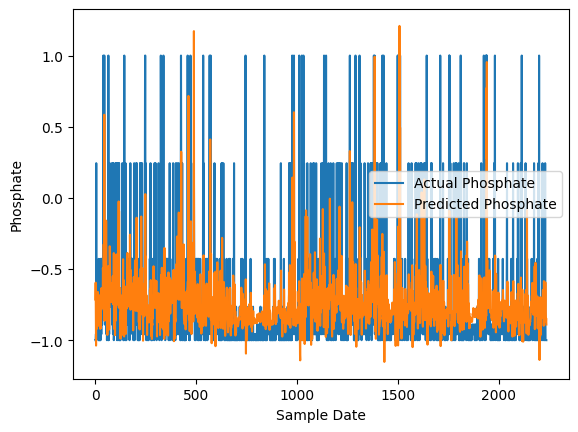

In [25]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Phosphate')
plt.plot(predicted, label='Predicted Phosphate')
plt.xlabel('Sample Date')
plt.ylabel('Phosphate')
plt.legend()
plt.show()

In [26]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([0.18000038, 0.2505527 , 0.11974479, ..., 0.08662747, 0.10169464,
       0.07566127])

In [27]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([0.01 , 0.01 , 0.035, ..., 0.01 , 0.01 , 0.01 ])

##### Adjusted to actual Phosphate conc training data LSTM plots

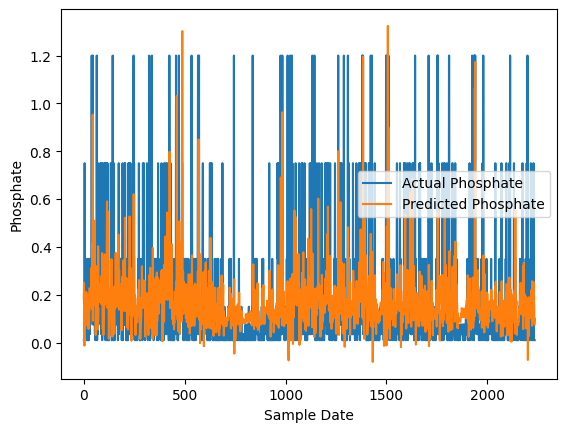

In [28]:
plt.plot(new_y_train, label='Actual Phosphate')
plt.plot(train_predictions, label='Predicted Phosphate')
plt.xlabel('Sample Date')
plt.ylabel('Phosphate')
plt.legend()
plt.show()

# Test data LSTM plots

In [29]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([0.0251498 , 0.09395244, 0.06825187, 0.07386211, 0.08045579,
       0.08566368, 0.09009593, 0.09419452, 0.09975039, 0.1441804 ,
       0.12401457, 0.20130548, 0.15562864, 0.21434822, 0.15285125,
       0.18285806, 0.20463562, 0.19839372, 0.16857757, 0.17317668,
       0.1925808 , 0.18587881, 0.21407085, 0.29379113, 0.04094354,
       0.06717562, 0.06669652, 0.12916604, 0.22029658, 0.10851569,
       0.14605695, 0.15871255, 0.12681465, 0.2003307 , 0.23921217,
       0.16978795, 0.1903296 , 0.13253186, 0.16965205, 0.42921768,
       0.20971999, 0.07867911, 0.16218927, 0.16686668, 0.32498083,
       0.1761909 , 0.17700042, 0.20591853, 0.17393874, 0.11503198,
       0.03673408, 0.13468006, 0.13806422, 0.13163492, 0.30168296,
       0.16595126, 0.12402514, 0.09612398, 0.16553661, 0.20897984,
       0.21703705, 0.2196286 , 0.13997726, 0.25818447, 0.21975124,
       0.1733379 , 0.20666563, 0.09137181, 0.28145727, 0.19487437,
       0.05964652, 0.03600131, 0.39069986, 1.21103358, 0.14599

In [30]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([0.01      , 0.01      , 0.035     , 0.035     , 0.035     ,
       0.035     , 0.035     , 0.035     , 0.14999999, 0.075     ,
       0.35      , 0.035     , 0.14999999, 0.035     , 0.075     ,
       0.14999999, 0.14999999, 0.075     , 0.75      , 0.35      ,
       0.075     , 0.075     , 0.01      , 0.035     , 0.035     ,
       0.035     , 0.075     , 0.35      , 0.075     , 0.075     ,
       0.14999999, 0.01      , 0.35      , 0.035     , 0.075     ,
       0.35      , 0.35      , 0.35      , 0.14999999, 0.035     ,
       0.14999999, 0.075     , 0.035     , 0.75      , 0.01      ,
       0.035     , 0.075     , 0.035     , 0.075     , 0.075     ,
       0.075     , 0.035     , 0.035     , 0.75      , 0.075     ,
       0.035     , 0.14999999, 0.75      , 0.075     , 0.75      ,
       0.035     , 0.01      , 0.14999999, 0.75      , 0.01      ,
       0.01      , 0.14999999, 0.14999999, 0.14999999, 0.035     ,
       1.2       , 0.075     , 0.35      , 0.035     , 0.35   

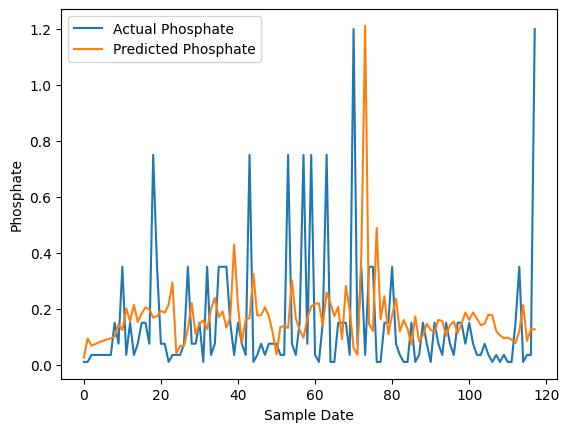

In [31]:
plt.plot(new_y_test, label='Actual Phosphate')
plt.plot(test_predictions, label='Predicted Phosphate')
plt.xlabel('Sample Date')
plt.ylabel('Phosphate')
plt.legend()
plt.show()
